In [1]:
## Daniel Marten
## Plotting Mean Count Data

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statistics
import sys
import os
import statsmodels.api as sm
import statsmodels.stats.weightstats as sm_stats
import seaborn as sns
import scipy
import scipy.stats as scistats

from statsmodels.formula.api import ols as formula_OLS

from cmapPy.pandasGEXpress.parse_gct import parse as tpm_parser

from collections import Counter
import re
import math
import warnings
import pandas as pd
import qtl.io as io
import qtl.norm as norm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Table containing mean read count data for 6 tissue categories and all 54 tissues for all genes-and-controls
df5 = pd.read_csv('joined_54tissue_6group_df5_21436genes_47removed_7805orf_geneid.tsv',sep='\t',index_col='Name')



/var/folders/29/nl14y27n0516tj91qh8q3njh0000gq/T/ipykernel_74733/363006299.py:2: DtypeWarning: Columns (68,71,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv('joined_54tissue_6group_df5_21436genes_47removed_7805orf_geneid.tsv',sep='\t',index_col='Name')


In [3]:
df5.evoera5.value_counts()

evoera5
1-Ancient                       14845
6-Intergenic ORF Control         3916
7-Intergenic Non-ORF Control     3889
2-Metazoa                        2253
5-Primate                        2069
3-Chordate                       1584
4-Mammal                          685
Name: count, dtype: int64

In [4]:
df5.annotation.value_counts()

annotation
annotated                   19334
orf                          3916
norf                         3889
Unannotated With Overlap     1811
Unannotated No Overlap        291
Name: count, dtype: int64

1811+291

In [5]:
date_name = '20231207' # variable for versioned plotting

In [6]:
# Only select to eras and 6 major tissue catagories, no metadata included
df6_plotting = df5[['brain','ecto','meso','endo','evoera5','testis','ovary']]
df6 = df6_plotting.rename(columns={
    'brain':'1-Brain',
    'ecto':'2-Ecto',
    'meso':'3-Meso',
    'endo':'4-Endo',
    'testis':'6-Testis',
    'ovary':'5-Ovary'})
df6 = pd.melt(frame=df6,id_vars=['evoera5'],var_name='Germ',value_name='Mean Count',ignore_index=False)

In [7]:
# IMPORTANT METHODS - for log plots in 6 tissue categories, replaced zero values with this value 
smallest_germ_nonzero = min(df6[df6['Mean Count']>0]['Mean Count'])

df6['log10'] = np.log10([xi + smallest_germ_nonzero for xi in df6['Mean Count']])

smallest_germ_nonzero

1.5714285714285715e-05

In [8]:
# lowest Mean Count value here
lowest_nonzero_mean = min(df6[df6['Mean Count']>0]['Mean Count'])
lowest_nonzero_mean

1.5714285714285715e-05

In [9]:
df6[df6['Mean Count']==smallest_germ_nonzero]

evoera5  \
Name                                                                               
GRCh38.Ens89.dna_rm.chr4.intergenic_gt122:43528...  7-Intergenic Non-ORF Control   

                                                      Germ  Mean Count  \
Name                                                                     
GRCh38.Ens89.dna_rm.chr4.intergenic_gt122:43528...  3-Meso    0.000016   

                                                       log10  
Name                                                          
GRCh38.Ens89.dna_rm.chr4.intergenic_gt122:43528... -4.502675

In [10]:
# Set up dictionaries for colors for all tissue and evolutionary categories 
germ_colours = {'1-Brain': (0.9611322333811573, 0.5992599234815877, 0.8505601386896218),
 '2-Ecto': (0.9999999999999999, 0.5820811976242779, 0.2131372549019609),
 '3-Meso': (0.9418548980857167, 0.199125494071146, 0.20336966209408627),
 '4-Endo': (0.055808823529411744, 0.5518872549019604, 0.8957598039215686),
 '5-Ovary': (0.13303921568627453, 0.7869607843137254, 0.13303921568627453),
 '6-Testis': (0.6662655153804639, 0.4899973016729626, 0.8268654434250764)}

germ_color_list = []
for xi,yi in germ_colours.items():
    germ_color_list.append(yi)
    
print(germ_color_list)

era_five_colours = {'1-Ancient': '#ffff00', # very yellow
 '2-Metazoa': (0.0, 0.5772549019607842, 0.0), # deep green
 '3-Chordate': '#F8766D',# salmon
 '4-Mammal': '#619CFF', # blue
 '5-Primate': '#ff7f0e', # orange
 '6-Intergenic ORF Control':(0.6662655153804639, 0.4899973016729626, 0.8268654434250764),  # purple            
 '7-Intergenic Non-ORF Control':(0.13303921568627453, 0.7869607843137254, 0.13303921568627453), # lime green
}

[(0.9611322333811573, 0.5992599234815877, 0.8505601386896218), (0.9999999999999999, 0.5820811976242779, 0.2131372549019609), (0.9418548980857167, 0.199125494071146, 0.20336966209408627), (0.055808823529411744, 0.5518872549019604, 0.8957598039215686), (0.13303921568627453, 0.7869607843137254, 0.13303921568627453), (0.6662655153804639, 0.4899973016729626, 0.8268654434250764)]


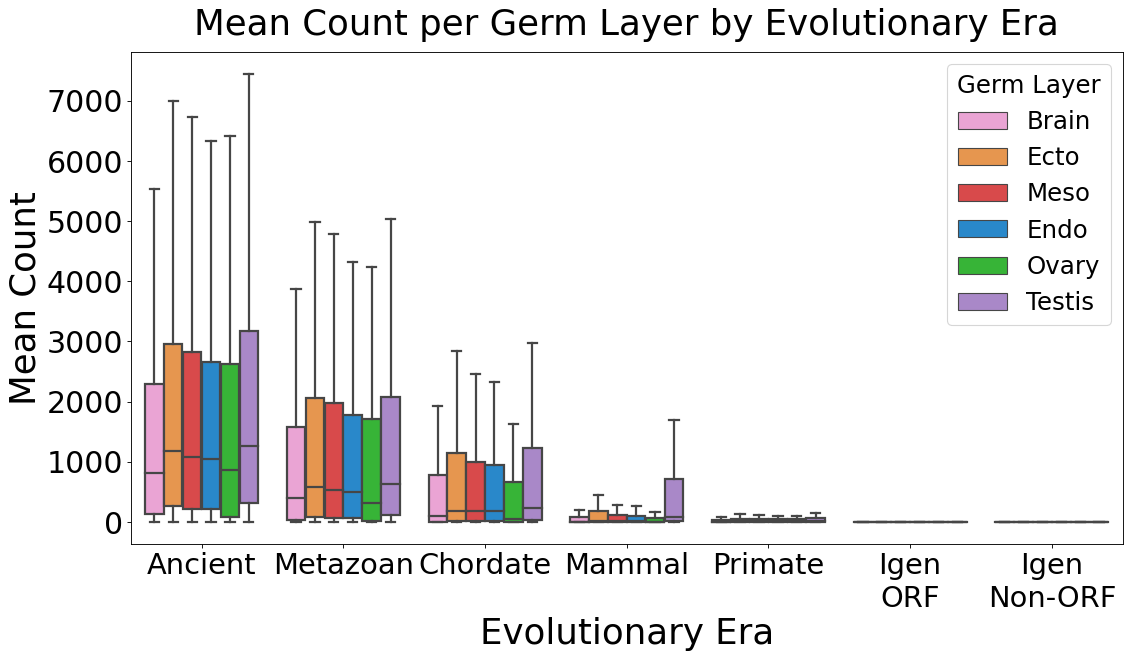

In [11]:
# PLOT SET 1 - Mean Count per Germ Layer by Evolutionary Era in 5 Era Setup
for config in ['evoera5']:
    
    df6_temp = df6.sort_values(by=[config,'Germ'])
    df6_temp['Germ'] = [germitext.split('-')[-1] for germitext in df6_temp['Germ']]

    plt.figure(figsize=(16,8), dpi=80)
    sns.boxplot(data=df6_temp,x=config,y='Mean Count',hue='Germ',showfliers=False,linewidth=2,palette=germ_color_list)
    plt.xlabel('Evolutionary Era',size=32)
    plt.ylabel('Mean Count',size=32)
    xOnes,xTwos = plt.xticks()
    
    xfont = 26
    if config=='evoera5':
        xTwos = ['Ancient','Metazoan','Chordate','Mammal','Primate','Igen\nORF','Igen\nNon-ORF']
    lablos = ['Brain','Ecto','Meso','Endo','Ovary','Testis']
    plt.xticks(xOnes,xTwos,size=xfont)
    plt.yticks(size=27)
    plt.legend(title='Germ Layer',title_fontsize=22,fontsize=22,bbox_to_anchor=(1.00, 1))
    plt.title('Mean Count per Germ Layer by Evolutionary Era',size=32,pad=15)

    if config=='evoera5':
        config='five_eras'

    image_name = f'fig1-meancount-germ-by-{config}-colorful-metazoanigenfix-{date_name}'
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/png/{image_name}.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/pdf/{image_name}.pdf',bbox_inches="tight")

    plt.show()

In [12]:
# Create df6 No Controls (_nc)
df6_nc = df6[~df6.evoera5.isin(['6-Intergenic ORF Control','7-Intergenic Non-ORF Control'])]
df6_nc.evoera5.value_counts()

evoera5
1-Ancient     89070
2-Metazoa     13518
5-Primate     12414
3-Chordate     9504
4-Mammal       4110
Name: count, dtype: int64

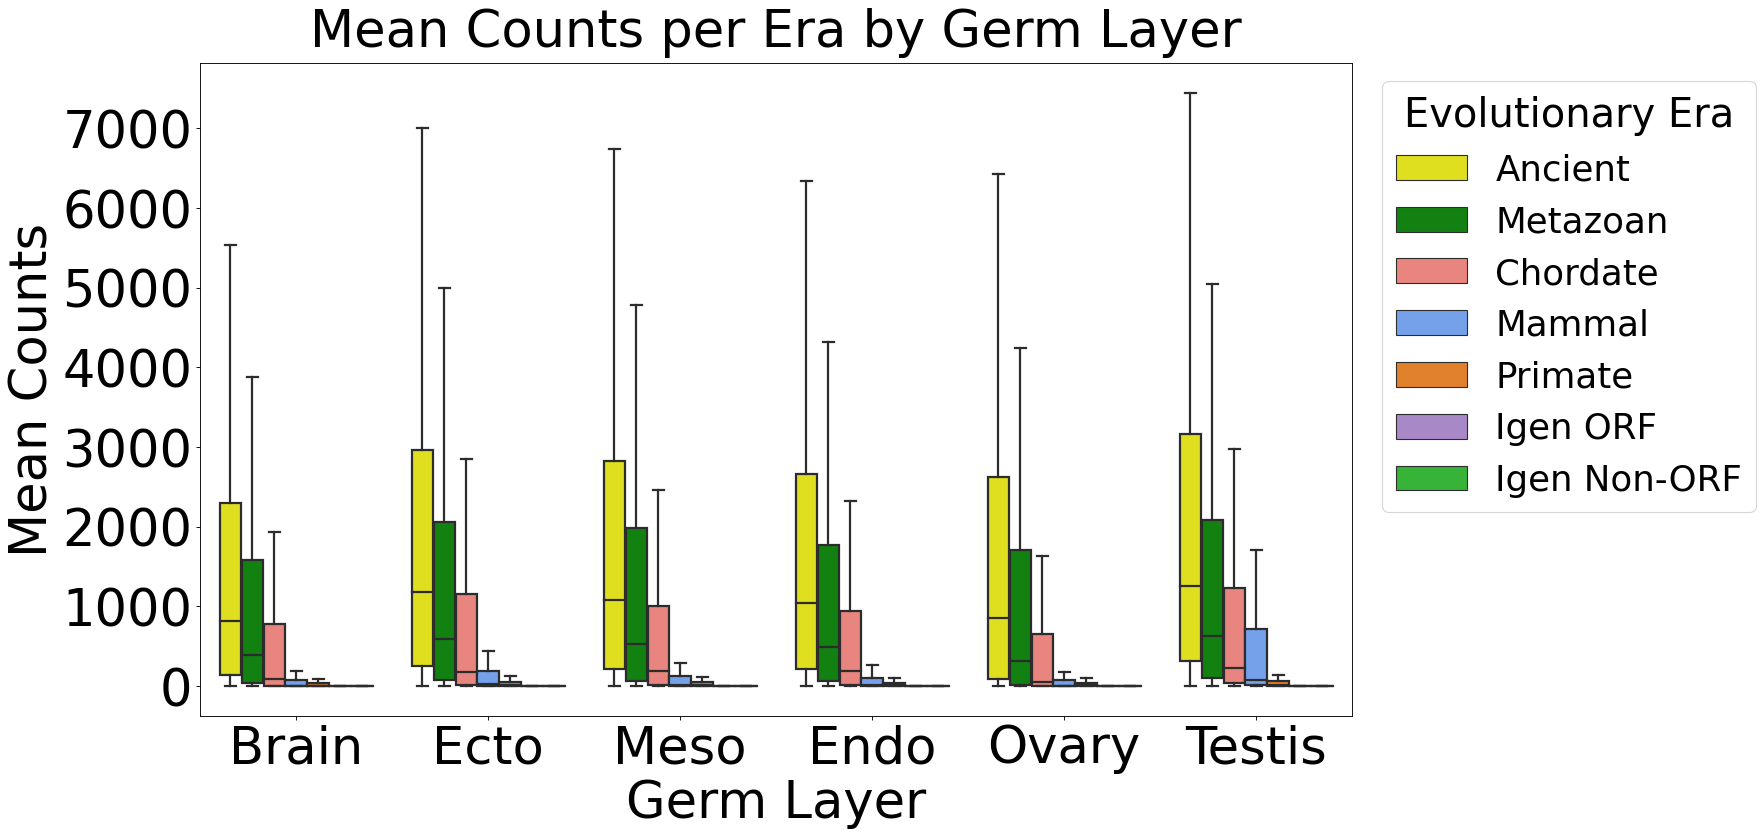

In [13]:
# PLOT SET 2 - M.C.s per Era, split by Germ Layer
# (flipped version of set #1)
for config in ['evoera5']:
    
    df6_temp = df6.sort_values(by=[config,'Germ']).copy()
    df6_temp['Germ'] = [germitext.split('-')[-1] for germitext in df6_temp['Germ']]
    df6_temp[config] = [configii.split('-')[-1] for configii in df6_temp[config]]
    df6_temp[config] = df6_temp[config].replace('Intergenic ORF Control','Igen ORF')
    df6_temp[config] = df6_temp[config].replace('ORF Control','Igen Non-ORF')
    df6_temp[config] = df6_temp[config].replace('Metazoa','Metazoan')

    if config == 'evoera5':
        paly = [yi for xi,yi in era_five_colours.items()]

    plt.figure(figsize=(18,12), dpi=80)
    sns.boxplot(data=df6_temp,x='Germ',y='Mean Count',hue=config,showfliers=False,linewidth=2,palette=paly)
    plt.xlabel('Germ Layer',size=46)
    plt.ylabel('Mean Counts',size=46)
    
    xOnes,xTwos = plt.xticks()
    
    plt.xticks(size=46)
    plt.yticks(size=46)
    plt.legend(bbox_to_anchor=(1.01, 1),title='Evolutionary Era',title_fontsize=36,fontsize=32)
    plt.title('Mean Counts per Era by Germ Layer',size=46,pad=15)
    plt.subplots_adjust(bottom=0.2,left=0.1)

    if config=='evoera5':
        config='five_eras'
    
    image_name = f'fig2-meancount-{config}-by-germ-colorful-metazoanigenfix-{date_name}'
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/png/{image_name}.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/pdf/{image_name}.pdf',bbox_inches="tight")



    plt.show()

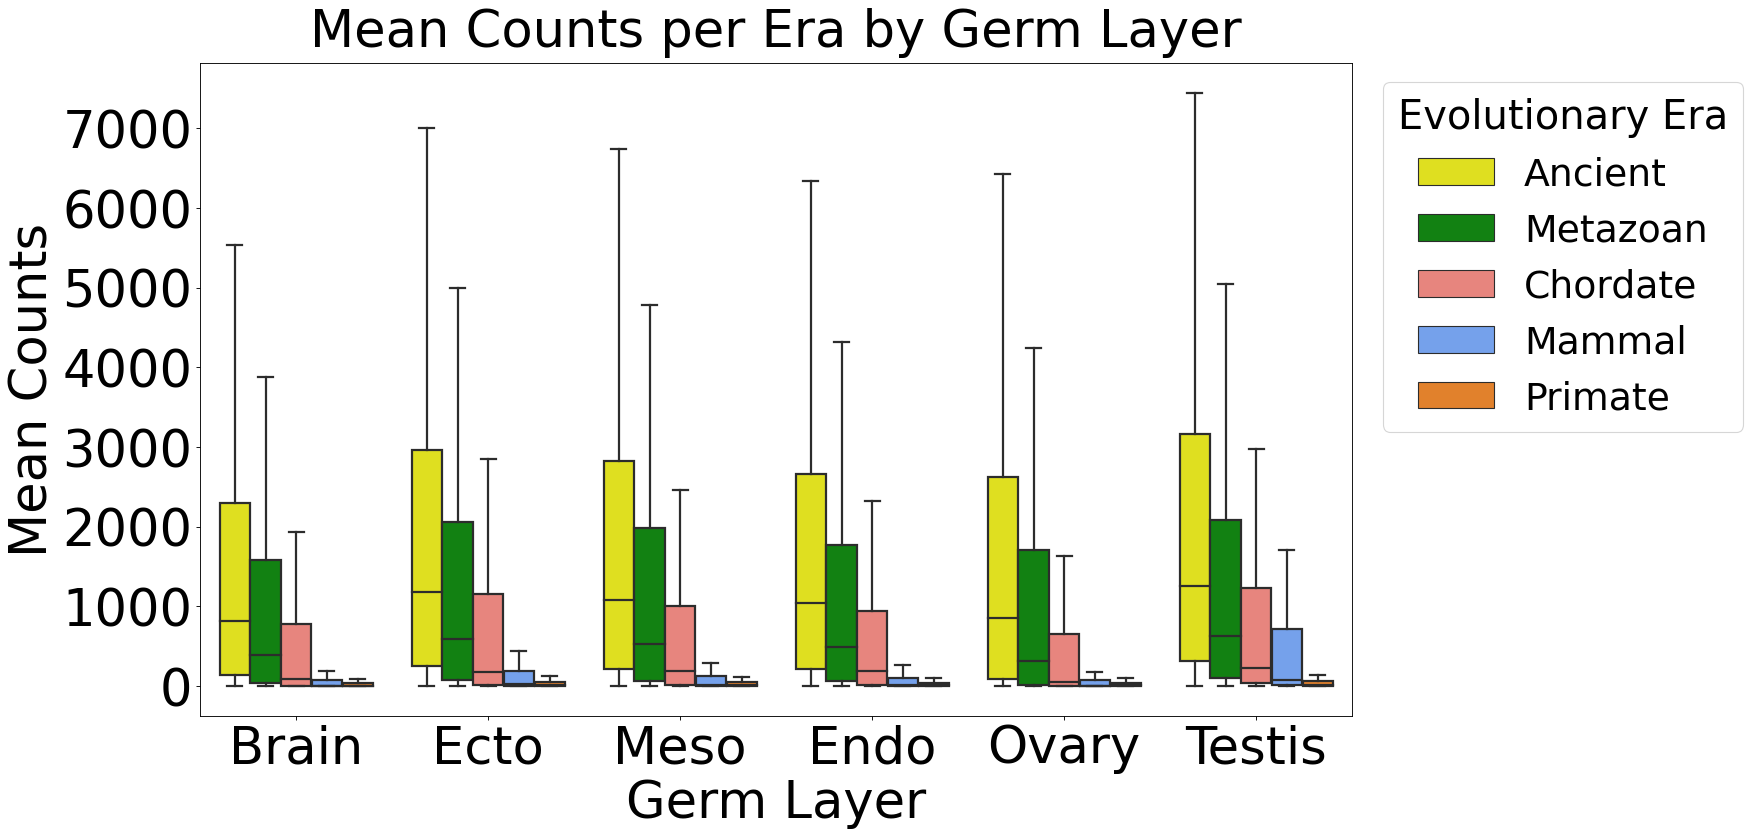

In [14]:
# M.C.s per Era by Germ Layer without controls
# Plot Set #3
for config in ['evoera5']:
    
    df6_temp = df6[~df6[config].str.contains('Control')].sort_values(by=[config,'Germ']).copy()
    df6_temp['Germ'] = [germitext.split('-')[-1] for germitext in df6_temp['Germ']]
    df6_temp[config] = [configii.split('-')[-1] for configii in df6_temp[config]]
    df6_temp[config] = df6_temp[config].replace('Intergenic ORF Control','Igen ORF')
    df6_temp[config] = df6_temp[config].replace('ORF Control','Igen Non-ORF')
    df6_temp[config] = df6_temp[config].replace('Metazoa','Metazoan')

    
    if config == 'evoera5':
        paly = [yi for xi,yi in era_five_colours.items()]

    plt.figure(figsize=(18,12), dpi=80)
    sns.boxplot(data=df6_temp,x='Germ',y='Mean Count',hue=config,showfliers=False,linewidth=2,palette=paly)
    plt.xlabel('Germ Layer',size=46)
    plt.ylabel('Mean Counts',size=46)
    plt.xticks(size=46)
    plt.yticks(size=46)
    plt.legend(bbox_to_anchor=(1.01, 1),title='Evolutionary Era',title_fontsize=36,fontsize=34)
    plt.title('Mean Counts per Era by Germ Layer',size=46,pad=15)
    plt.subplots_adjust(bottom=0.2,left=0.1)

    if config=='evoera5':
        config='five_eras'
    
    image_name = f'fig2-meancount-{config}-nocontrol-by-germ-colorful-metazoanigenfix-{date_name}'
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/png/{image_name}.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/pdf/{image_name}.pdf',bbox_inches="tight")

    plt.show()

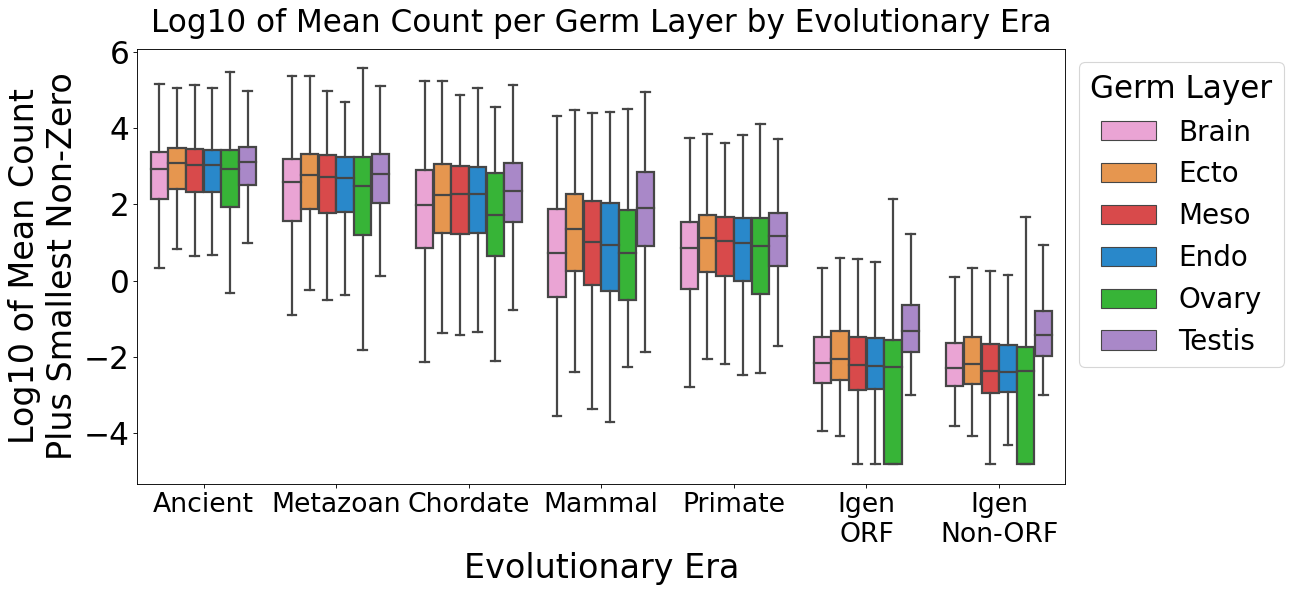

In [15]:
# Plot set #4 - Log10 of Mean Count per Germ Layer by Evolutionary Era

for config in ['evoera5']:

    plt.figure(figsize=(16,8), dpi=80)
    df6_temp = df6.sort_values(by=['evoera5','Germ']).copy()
    df6_temp['Germ'] = [germyval.split('-')[-1] for germyval in df6_temp['Germ']]
    sns.boxplot(data=df6_temp,x=config,y='log10',hue='Germ',showfliers=False,linewidth=2,palette=germ_color_list)
    plt.xlabel('Evolutionary Era',size=30)
    plt.ylabel('Log10 of Mean Count\nPlus Smallest Non-Zero',size=30)
    xOnes,xTwos = plt.xticks()

    if config=='evoera5':
        xTwos = ['Ancient','Metazoan','Chordate','Mammal','Primate','Igen\nORF','Igen\nNon-ORF']

    xfont = 24
    if config == 'evoera':
        xfont += 2
    plt.xticks(xOnes,xTwos,size=xfont)
    plt.yticks(size=28)
    plt.legend(title='Germ Layer',title_fontsize=28,fontsize=25,bbox_to_anchor=(1.00, 1))
    plt.title('Log10 of Mean Count per Germ Layer by Evolutionary Era',size=28,pad=15)
    plt.subplots_adjust(left=0.175,bottom=0.2)

    if config=='evoera5':
        config='five_eras'
    
    image_name = f'fig1-log10meancount-germ-by-{config}-manual-smallestnonzero-colorful-metazoanigenfix-{date_name}'
#     # plt.savefig(f'marten-0830-meancount-and-tpm/meancount/{image_name}.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/png/{image_name}.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/pdf/{image_name}.pdf',bbox_inches="tight")

    plt.show()

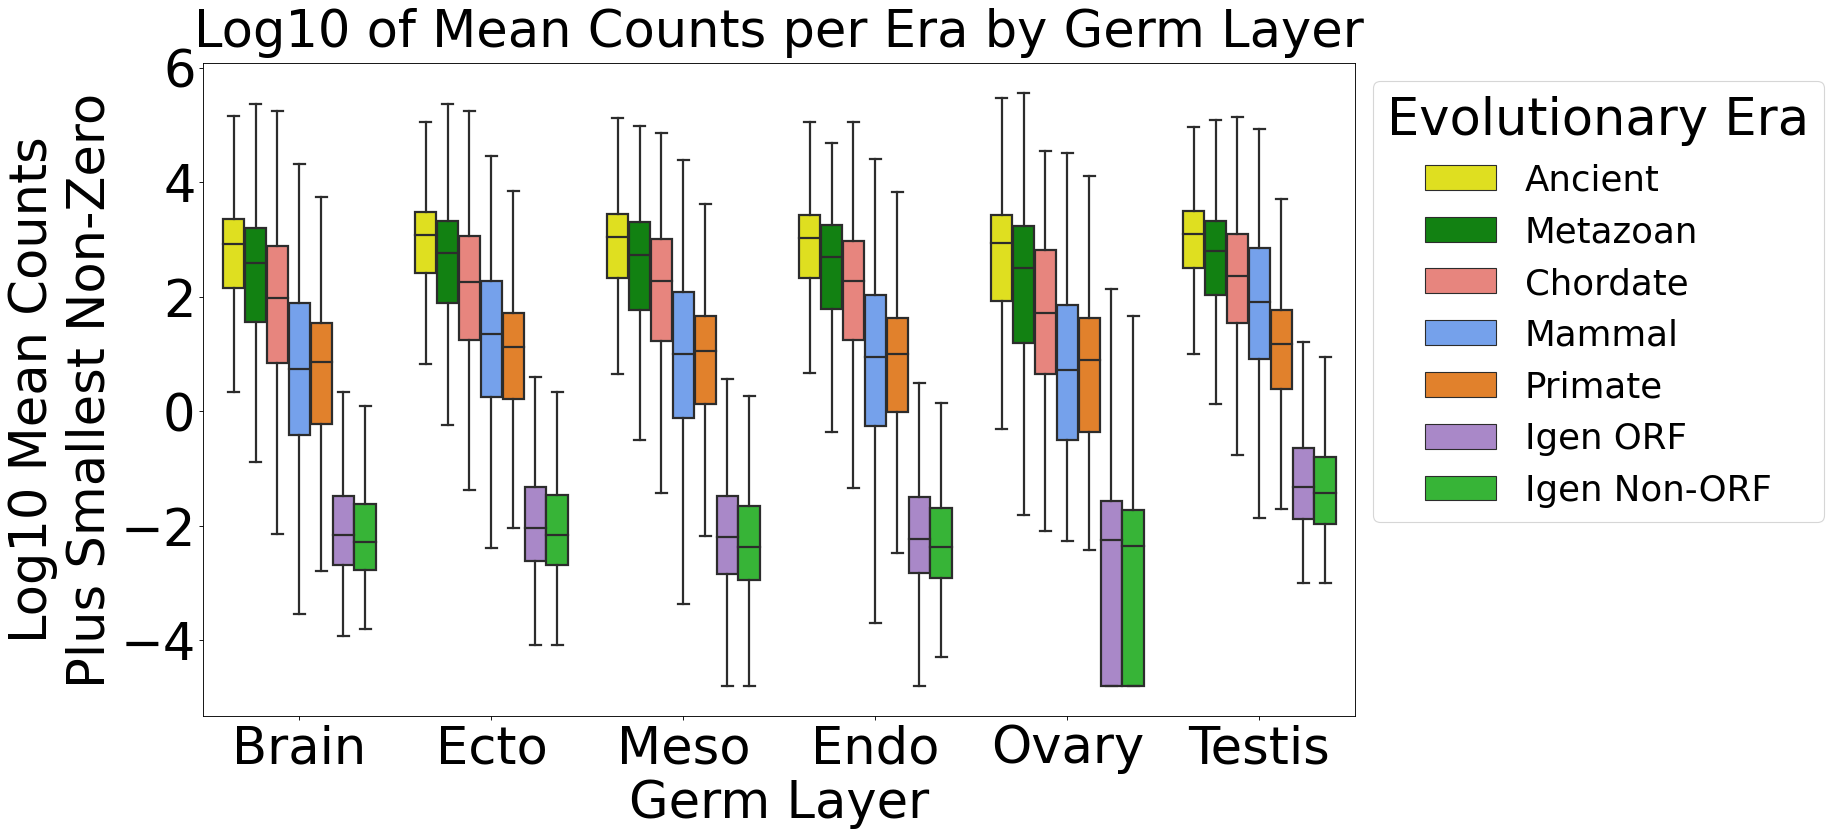

In [16]:
# Plot Set #5 - Log10 of Mean Counts per Era by Germ Layer

for config in ['evoera5']:
    
    df6_temp = df6.copy()
    df6_temp = df6_temp.sort_values(by=['Germ',config])
    df6_temp[config] = [tabloos.split('-')[-1] for tabloos in df6_temp[config]]
    df6_temp['Germ'] = [germos.split('-')[-1] for germos in df6_temp['Germ']]
    df6_temp[config] = df6_temp[config].replace('Metazoa','Metazoan')
    df6_temp[config] = df6_temp[config].replace('Intergenic ORF Control','Igen ORF')
    df6_temp[config] = df6_temp[config].replace('ORF Control','Igen Non-ORF')
    
    
    if config == 'evoera5':
        paly = []
        for x5,y5 in era_five_colours.items():
            paly.append(y5)
        lablees = ['Ancient','Metazoan','Chordate','Mammal','Primate','Igen ORF','Igen Non-ORF']
        
    plt.figure(figsize=(18,12), dpi=80)
    sns.boxplot(data=df6_temp,x='Germ',y='log10',hue=config,showfliers=False,linewidth=2,palette=paly)
    plt.xlabel('Germ Layer',size=46)
    plt.ylabel('Log10 Mean Counts\nPlus Smallest Non-Zero',size=46)
    xOnes,xTwos = plt.xticks()
    plt.xticks(size=46)
    plt.yticks(size=46)
    lablees = []
    plt.legend(bbox_to_anchor=(1.00, 1),title='Evolutionary Era',title_fontsize=46,fontsize=32)
    plt.title('Log10 of Mean Counts per Era by Germ Layer',size=46,pad=15)
    plt.subplots_adjust(bottom=0.2,left=0.1)
    
    if config=='evoera5':
        config='five_eras'
    
    image_name = f'fig2-log10meancount-{config}-smallestnonzero-by-germ-colorful-metazoanigenfix-{date_name}'
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/png/{image_name}.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/pdf/{image_name}.pdf',bbox_inches="tight")

    plt.show()

In [17]:
import json

In [18]:
with open('/Users/marten/dict_renaming.json') as json_file:
    tissue_dictionary = json.load(json_file)


In [19]:
govt_names = {}
for keyhere,valhere in tissue_dictionary.items():
    govt_names[valhere] = keyhere
    

In [20]:
# Df5 (not melted) selected only to relevant data - no metadata included 
df5_onlydata = df5.drop(['annotation', 'ps', 'description', 'plength', 'gapgene',
       'chr', 'oldlongtranscriptstarthg38', 'oldlongtranscriptendhg38',
       'strand', 'cdsstarthg38', 'cdsendhg38', 'proteinsequence',
       'cdssequence', 'inold', 'genestart', 'genestop', 'innew',
       'ORF_Control_Set', 'ORF_Gene_Length', 'ORF_Nucleic_Seq', 'ORF_AA_Seq',
       'ORF_Plength', 'Joined_Plength', 'Joined_Pseq', 'Joined_GeneSeq','evoera38','evoera538','geneid'],axis=1)

tissue_df = pd.melt(frame=df5_onlydata,id_vars=['brain','ecto','meso','endo','evoera5','annotation38'],var_name='tissuetype',value_name="mc",ignore_index=False)
tissue_df # same as df6 but with additional tissue information

brain        ecto        meso        endo    evoera5  \
Name                                                                        
Baz_Hs_1         19.246232   41.648061   93.516133   51.150869  5-Primate   
Baz_Hs_10       282.372045  315.618518  318.332461  307.241556  5-Primate   
Baz_Hs_103       43.601802   38.801797   40.294316   29.005099  5-Primate   
Baz_Hs_108       49.657373  104.445080  101.909756   51.059745  5-Primate   
Baz_Hs_112       34.158753   53.027348   49.781828   40.437216  5-Primate   
...                    ...         ...         ...         ...        ...   
vdp2013_S4_994   91.778383   42.850460   12.239880    2.614006  5-Primate   
vdp2013_S4_995   37.328562   88.950656   90.989704  105.934883  5-Primate   
vdp2013_S4_997   38.012142   35.344546   32.784148   35.794540  5-Primate   
vdp2013_S4_998  154.130740  229.637673  207.488502  196.535950  5-Primate   
vdp2013_S4_999    6.050038   19.823857   31.947813   24.430305  5-Primate   

                            annotation38           tissuetype         mc  
Name                                                                      
Baz_Hs_1        Unannotated With Overlap  adiposesubcutaneous  111.23101  
Baz_Hs_10       Unannotated With Overlap  adiposesubcutaneous  177.68898  
Baz_Hs_103      Unannotated With Overlap  adiposesubcutaneous   35.51803  
Baz_Hs_108      Unannotated With Overlap  adiposesubcutaneous  171.90412  
Baz_Hs_112      Unannotated With Overlap  adiposesubcutaneous   68.48757  
...                                  ...                  ...        ...  
vdp2013_S4_994  Unannotated With Overlap           wholeblood    2.79571  
vdp2013_S4_995  Unannotated With Overlap           wholeblood   28.26805  
vdp2013_S4_997  Unannotated With Overlap           wholeblood   20.00996  
vdp2013_S4_998  Unannotated With Overlap           wholeblood  111.39997  
vdp2013_S4_999  Unannotated With Overlap           wholeblood   28.07457  

[1579014 rows x 8 columns]

In [21]:
len(list(set(list(tissue_df.tissuetype)))) # verify we have the correct num of tissues 

54

In [22]:
sum(tissue_df.reset_index().duplicated(subset=['Name','tissuetype'])) # no duplications

0

In [23]:
# This analysis is by INDIVIDUAL TISSUES and will have a different smallest value than by category 
smallest_tissue_nonzero = min(tissue_df[tissue_df['mc']>0]['mc'])
smallest_tissue_nonzero

0.00023

In [24]:
tissue_df[tissue_df.mc==smallest_tissue_nonzero]

brain      ecto  \
Name                                                                     
GRCh38.Ens89.dna_rm.chr13.intergenic_gt122.orf:...  0.003568  0.002390   
GRCh38.Ens89.dna_rm.chr5.intergenic_gt122.orf:1...  0.005409  0.000133   
GRCh38.Ens89.dna_rm.chr7.intergenic_gt122.orf:1...  0.001158  0.001180   

                                                        meso      endo  \
Name                                                                     
GRCh38.Ens89.dna_rm.chr13.intergenic_gt122.orf:...  0.000747  0.001386   
GRCh38.Ens89.dna_rm.chr5.intergenic_gt122.orf:1...  0.001471  0.000881   
GRCh38.Ens89.dna_rm.chr7.intergenic_gt122.orf:1...  0.001441  0.002811   

                                                                     evoera5  \
Name                                                                           
GRCh38.Ens89.dna_rm.chr13.intergenic_gt122.orf:...  6-Intergenic ORF Control   
GRCh38.Ens89.dna_rm.chr5.intergenic_gt122.orf:1...  6-Intergenic ORF Control   
GRCh38.Ens89.dna_rm.chr7.intergenic_gt122.orf:1...  6-Intergenic ORF Control   

                                                   annotation38    tissuetype  \
Name                                                                            
GRCh38.Ens89.dna_rm.chr13.intergenic_gt122.orf:...          NaN  arterytibial   
GRCh38.Ens89.dna_rm.chr5.intergenic_gt122.orf:1...          NaN  arterytibial   
GRCh38.Ens89.dna_rm.chr7.intergenic_gt122.orf:1...          NaN  arterytibial   

                                                         mc  
Name                                                         
GRCh38.Ens89.dna_rm.chr13.intergenic_gt122.orf:...  0.00023  
GRCh38.Ens89.dna_rm.chr5.intergenic_gt122.orf:1...  0.00023  
GRCh38.Ens89.dna_rm.chr7.intergenic_gt122.orf:1...  0.00023

In [25]:
# Log10 Setup by tissue
tissue_df['Log10'] = np.log10([xi + smallest_tissue_nonzero for xi in tissue_df['mc']])

In [26]:
germ_dict={'ecto': [['Nerve_Tibial',
   'Skin Not Sun Exposed (Suprapubic)',
   'Skin_Sun_Exposed_Lower_leg',
   'Breast - Mammary Tissue',
   'Pituitary',
   'Adrenal Gland',
   'Brain - Cerebellum',
   'Brain - Cortex',
   'Cervix - Endocervix',
   'Minor Salivary Gland'],
  ['nervetibial',
   'skinnotsunexposedsuprapubic',
   'skinsunexposedlowerleg',
   'breastmammarytissue',
   'pituitary',
   'adrenalgland',
   'braincerebellum',
   'braincortex',
   'cervixendocervix',
   'minorsalivarygland']],
 'meso': [['Muscle - Skeletal',
   'Whole Blood',
   'Adipose - Subcutaneous',
   'Cells - Cultured fibroblasts',
   'Adipose - Visceral (Omentum)',
   'Esophagus - Muscularis',
   'Artery - Aorta',
   'Heart - Left Ventricle',
   'Heart - Atrial Appendage',
   'Spleen',
   'Prostate',
   'Artery - Coronary',
   'Artery - Tibial',
   'Cells - EBV-transformed lymphocytes',
   'Vagina',
   'Uterus',
   'Kidney - Cortex',
   'Bladder',
   'Cervix - Ectocervix',
   'Fallopian Tube',
   'Kidney - Medulla'],
  ['muscleskeletal',
   'wholeblood',
   'adiposesubcutaneous',
   'cellsculturedfibroblasts',
   'adiposevisceralomentum',
   'esophagusmuscularis',
   'arteryaorta',
   'heartleftventricle',
   'heartatrialappendage',
   'spleen',
   'prostate',
   'arterycoronary',
   'arterytibial',
   'cellsebvtransformedlymphocytes',
   'vagina',
   'uterus',
   'kidneycortex',
   'bladder',
   'cervixectocervix',
   'fallopiantube',
   'kidneymedulla']],
 'endo': [['Thyroid',
   'Lung',
   'Esophagus - Mucosa',
   'Colon - Transverse',
   'Esophagus - Gastroesophageal Junction',
   'Stomach',
   'Colon - Sigmoid',
   'Pancreas',
   'Liver',
   'Small Intestine - Terminal Ileum'],
  ['thyroid',
   'lung',
   'esophagusmucosa',
   'colontransverse',
   'esophagusgastroesophagealjunction',
   'stomach',
   'colonsigmoid',
   'pancreas',
   'liver',
   'smallintestineterminalileum']],
 'brain': [['Brain - Nucleus accumbens (basal ganglia)',
   'Brain - Caudate (basal ganglia)',
   'Brain - Cerebellar Hemisphere',
   'Brain - Frontal Cortex (BA9)',
   'Brain - Hypothalamus',
   'Brain - Putamen (basal ganglia)',
   'Brain - Hippocampus',
   'Brain - Anterior cingulate cortex (BA24)',
   'Brain - Amygdala',
   'Brain - Spinal cord (cervical c-1)',
   'Brain - Substantia nigra',
   'Brain - Cerebellum',
   'Brain - Cortex'],
  ['brainnucleusaccumbensbasalganglia',
   'braincaudatebasalganglia',
   'braincerebellarhemisphere',
   'brainfrontalcortexba9',
   'brainhypothalamus',
   'brainputamenbasalganglia',
   'brainhippocampus',
   'brainanteriorcingulatecortexba24',
   'brainamygdala',
   'brainspinalcordcervicalc1',
   'brainsubstantianigra',
   'braincerebellum',
   'braincortex']],
 'germline': [['Testis', 'Ovary'], ['testis', 'ovary']]}

In [31]:
# Now graph of all individual tissues 

In [32]:
# some case control for coming analysis
for xi,yi in germ_dict.items():
    if xi != 'germline':
        undercase_keys = yi[1]
        germ_df = tissue_df[tissue_df['tissuetype'].isin(undercase_keys)]


In [33]:
# Create a repeating color palette
repeating = sns.color_palette("tab10",10)
del repeating[7]
del repeating[-1]
repeating

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

In [34]:
# List of uppercase and separated names 
xTwo = list(list(govt_names.values())[:54])
xTwo

['Adipose_Subcutaneous',
 'Adipose_Visceral_Omentum',
 'Adrenal_Gland',
 'Artery_Aorta',
 'Artery_Coronary',
 'Artery_Tibial',
 'Bladder',
 'Brain_Amygdala',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Caudate_basal_ganglia',
 'Brain_Cerebellar_Hemisphere',
 'Brain_Cerebellum',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Hippocampus',
 'Brain_Hypothalamus',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Putamen_basal_ganglia',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Substantia_nigra',
 'Breast_Mammary_Tissue',
 'Cells_Cultured_fibroblasts',
 'Cells_EBV-transformed_lymphocytes',
 'Cervix_Ectocervix',
 'Cervix_Endocervix',
 'Colon_Sigmoid',
 'Colon_Transverse',
 'Esophagus_Gastroesophageal_Junction',
 'Esophagus_Mucosa',
 'Esophagus_Muscularis',
 'Fallopian_Tube',
 'Heart_Atrial_Appendage',
 'Heart_Left_Ventricle',
 'Kidney_Cortex',
 'Kidney_Medulla',
 'Liver',
 'Lung',
 'Minor_Salivary_Gland',
 'Muscle_Skeletal',
 'Nerve_Tibial',
 'Ovary',
 'Pancreas',
 'Pituitary',

In [35]:
# Temp dataframe for coming analysis, with renaming done to fit graphing standards

v5_temp = tissue_df.sort_values(by=['evoera5','tissuetype']).copy()
v5_temp['evoera5'] = [v5ii.split('-')[1] for v5ii in v5_temp['evoera5']]
v5_temp['evoera5'] = v5_temp['evoera5'].replace('Intergenic ORF Control','Igen ORF')
v5_temp['evoera5'] = v5_temp['evoera5'].replace('Intergenic Non','Igen Non-ORF')
v5_temp['evoera5'] = v5_temp['evoera5'].replace('Metazoa','Metazoan')

print(v5_temp['evoera5'].unique())

['Ancient' 'Metazoan' 'Chordate' 'Mammal' 'Primate' 'Igen ORF'
 'Igen Non-ORF']


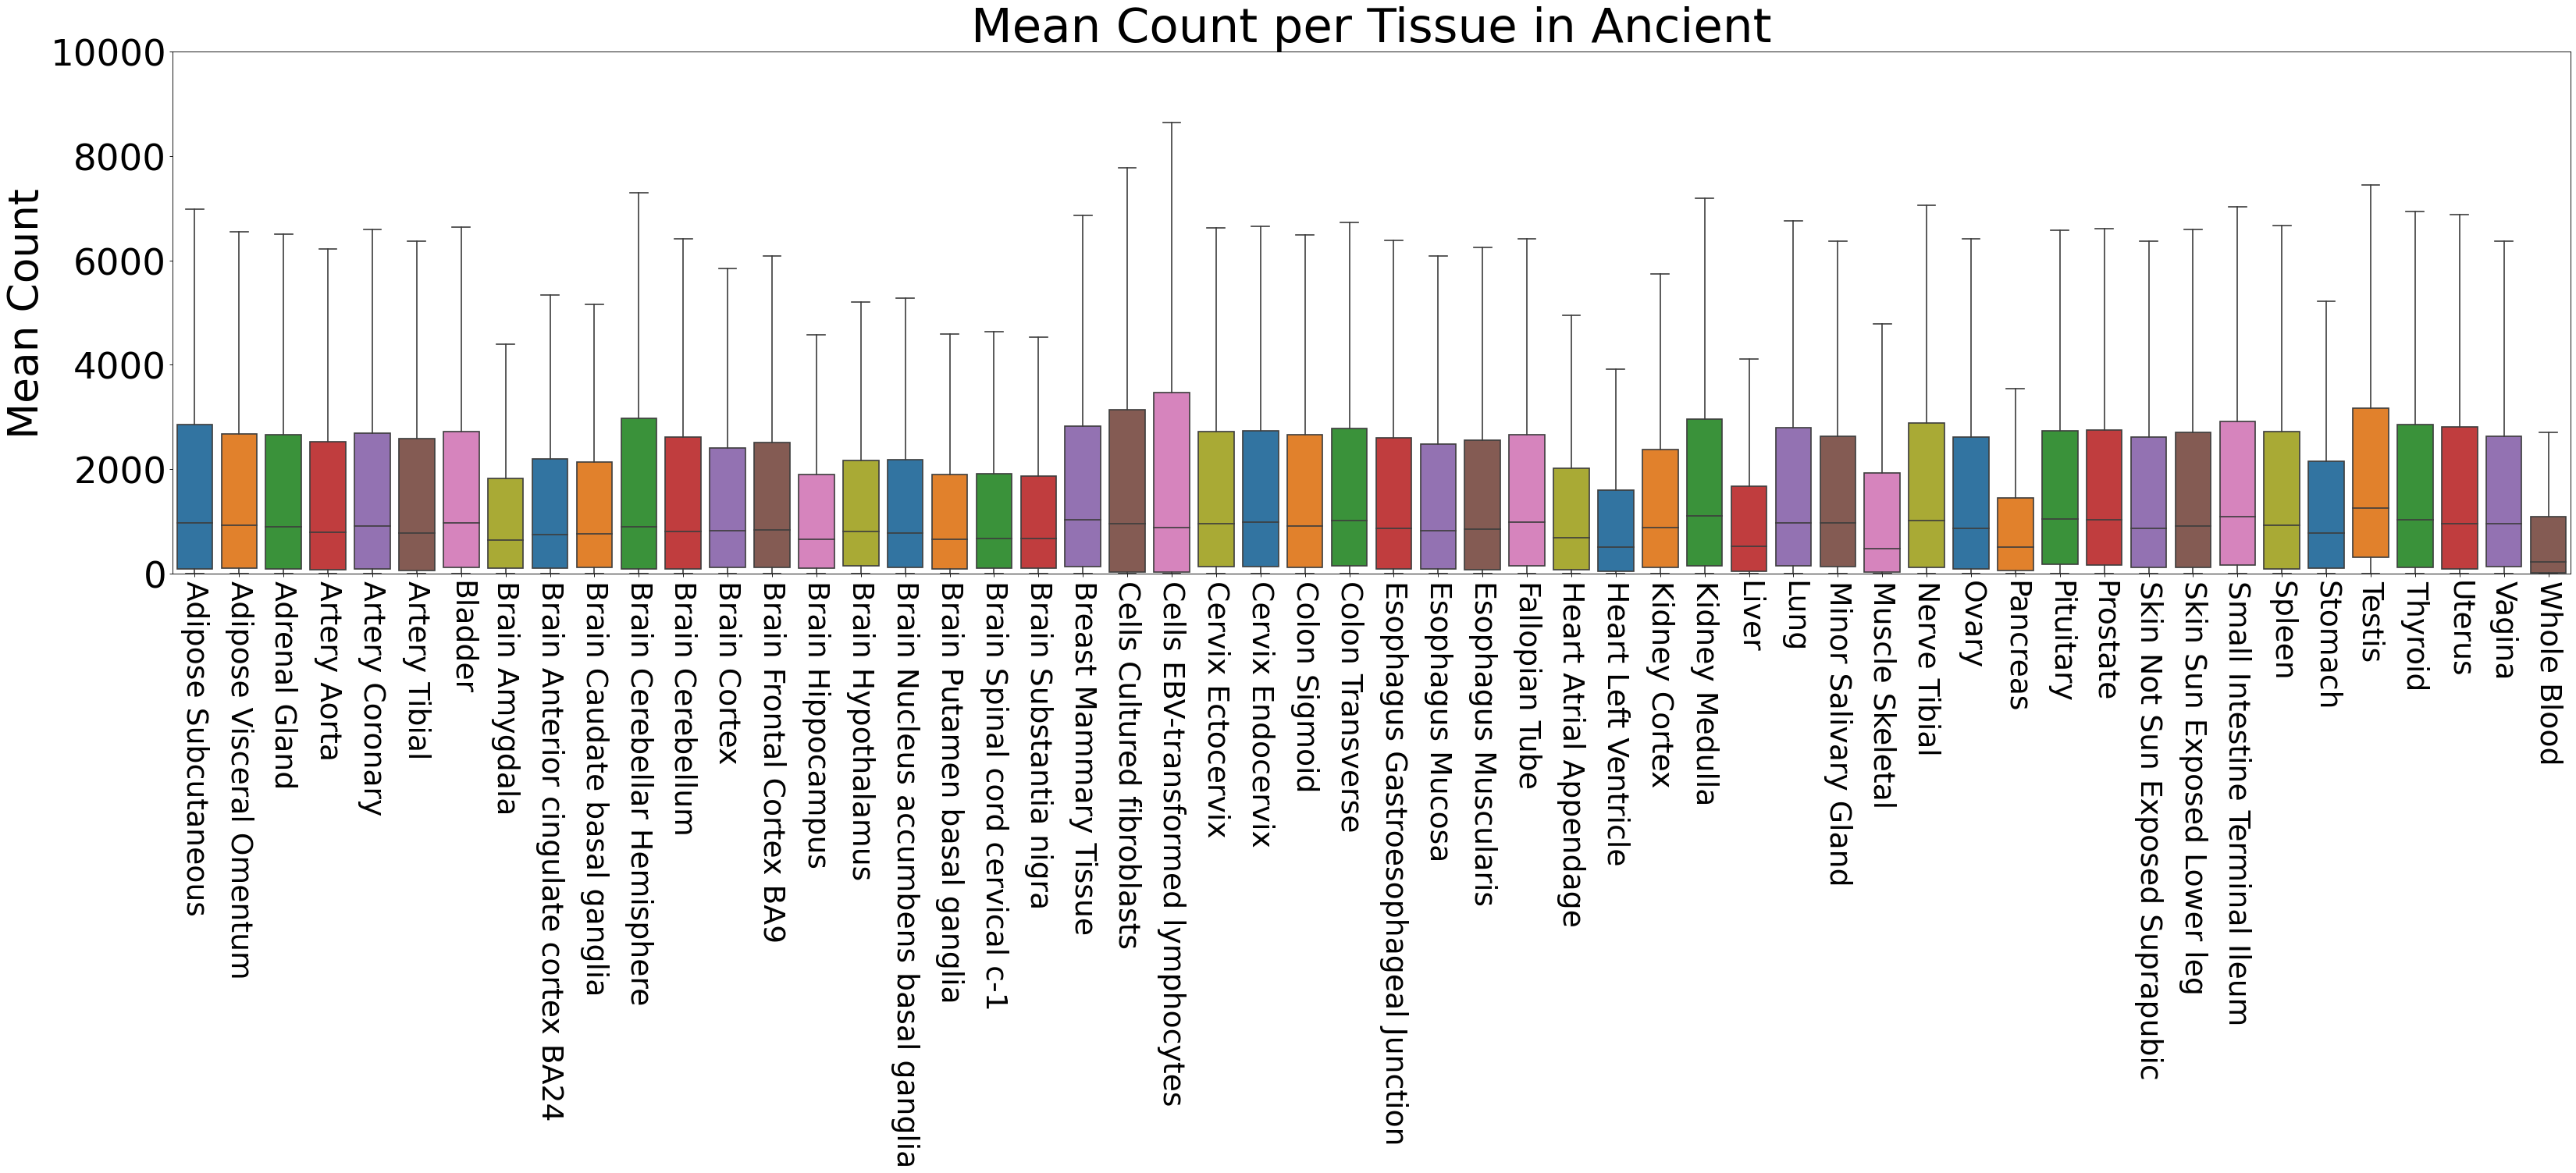

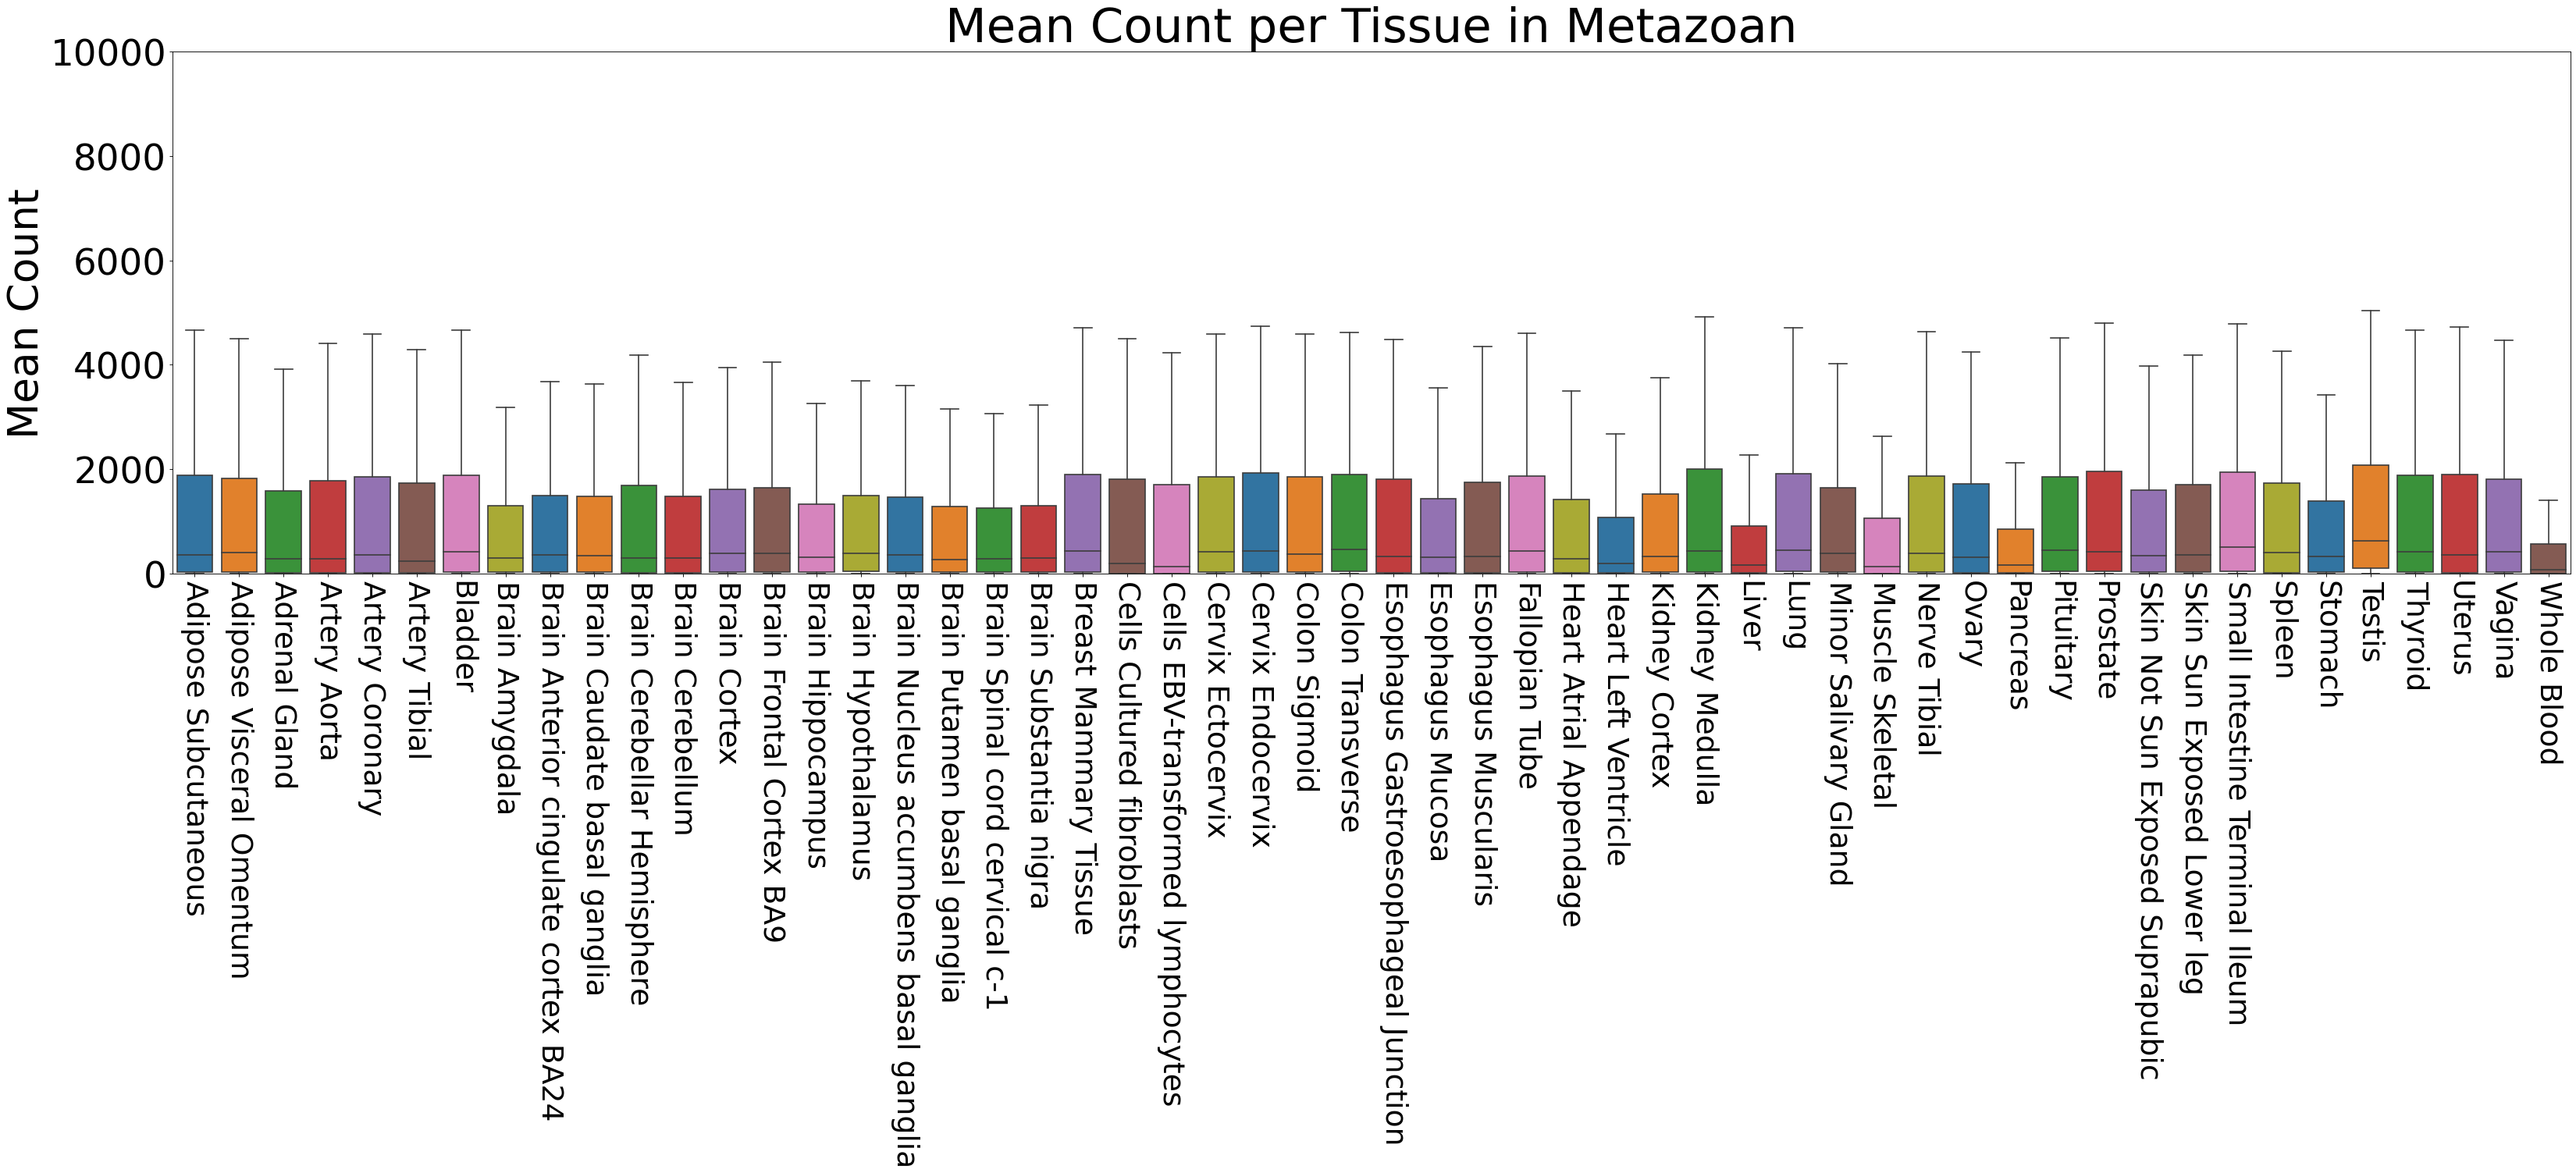

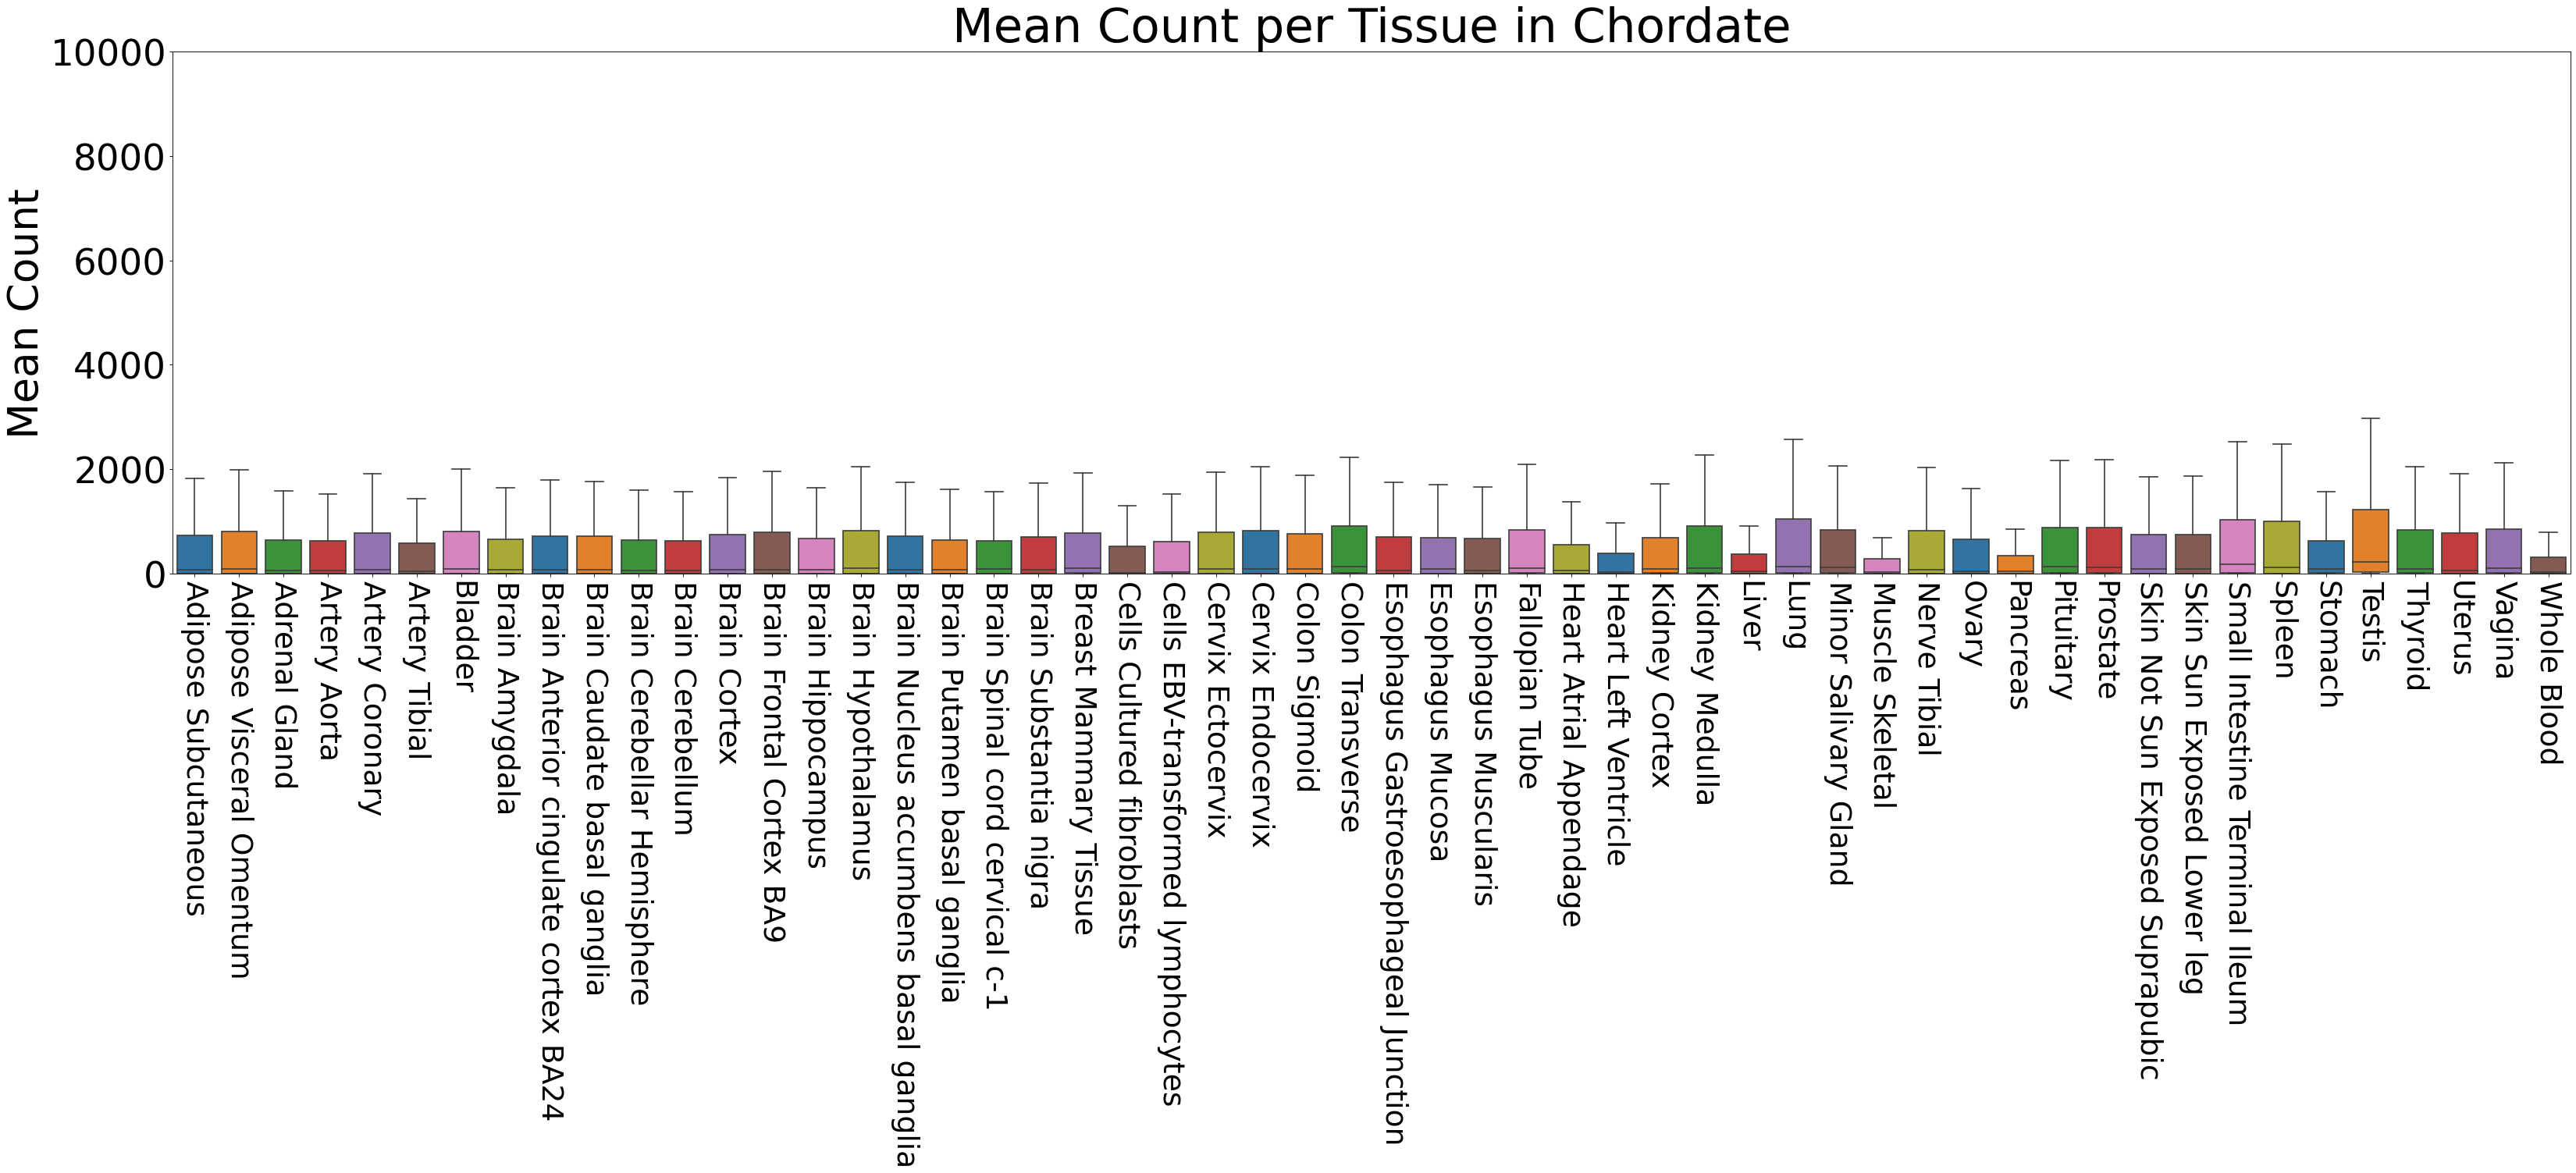

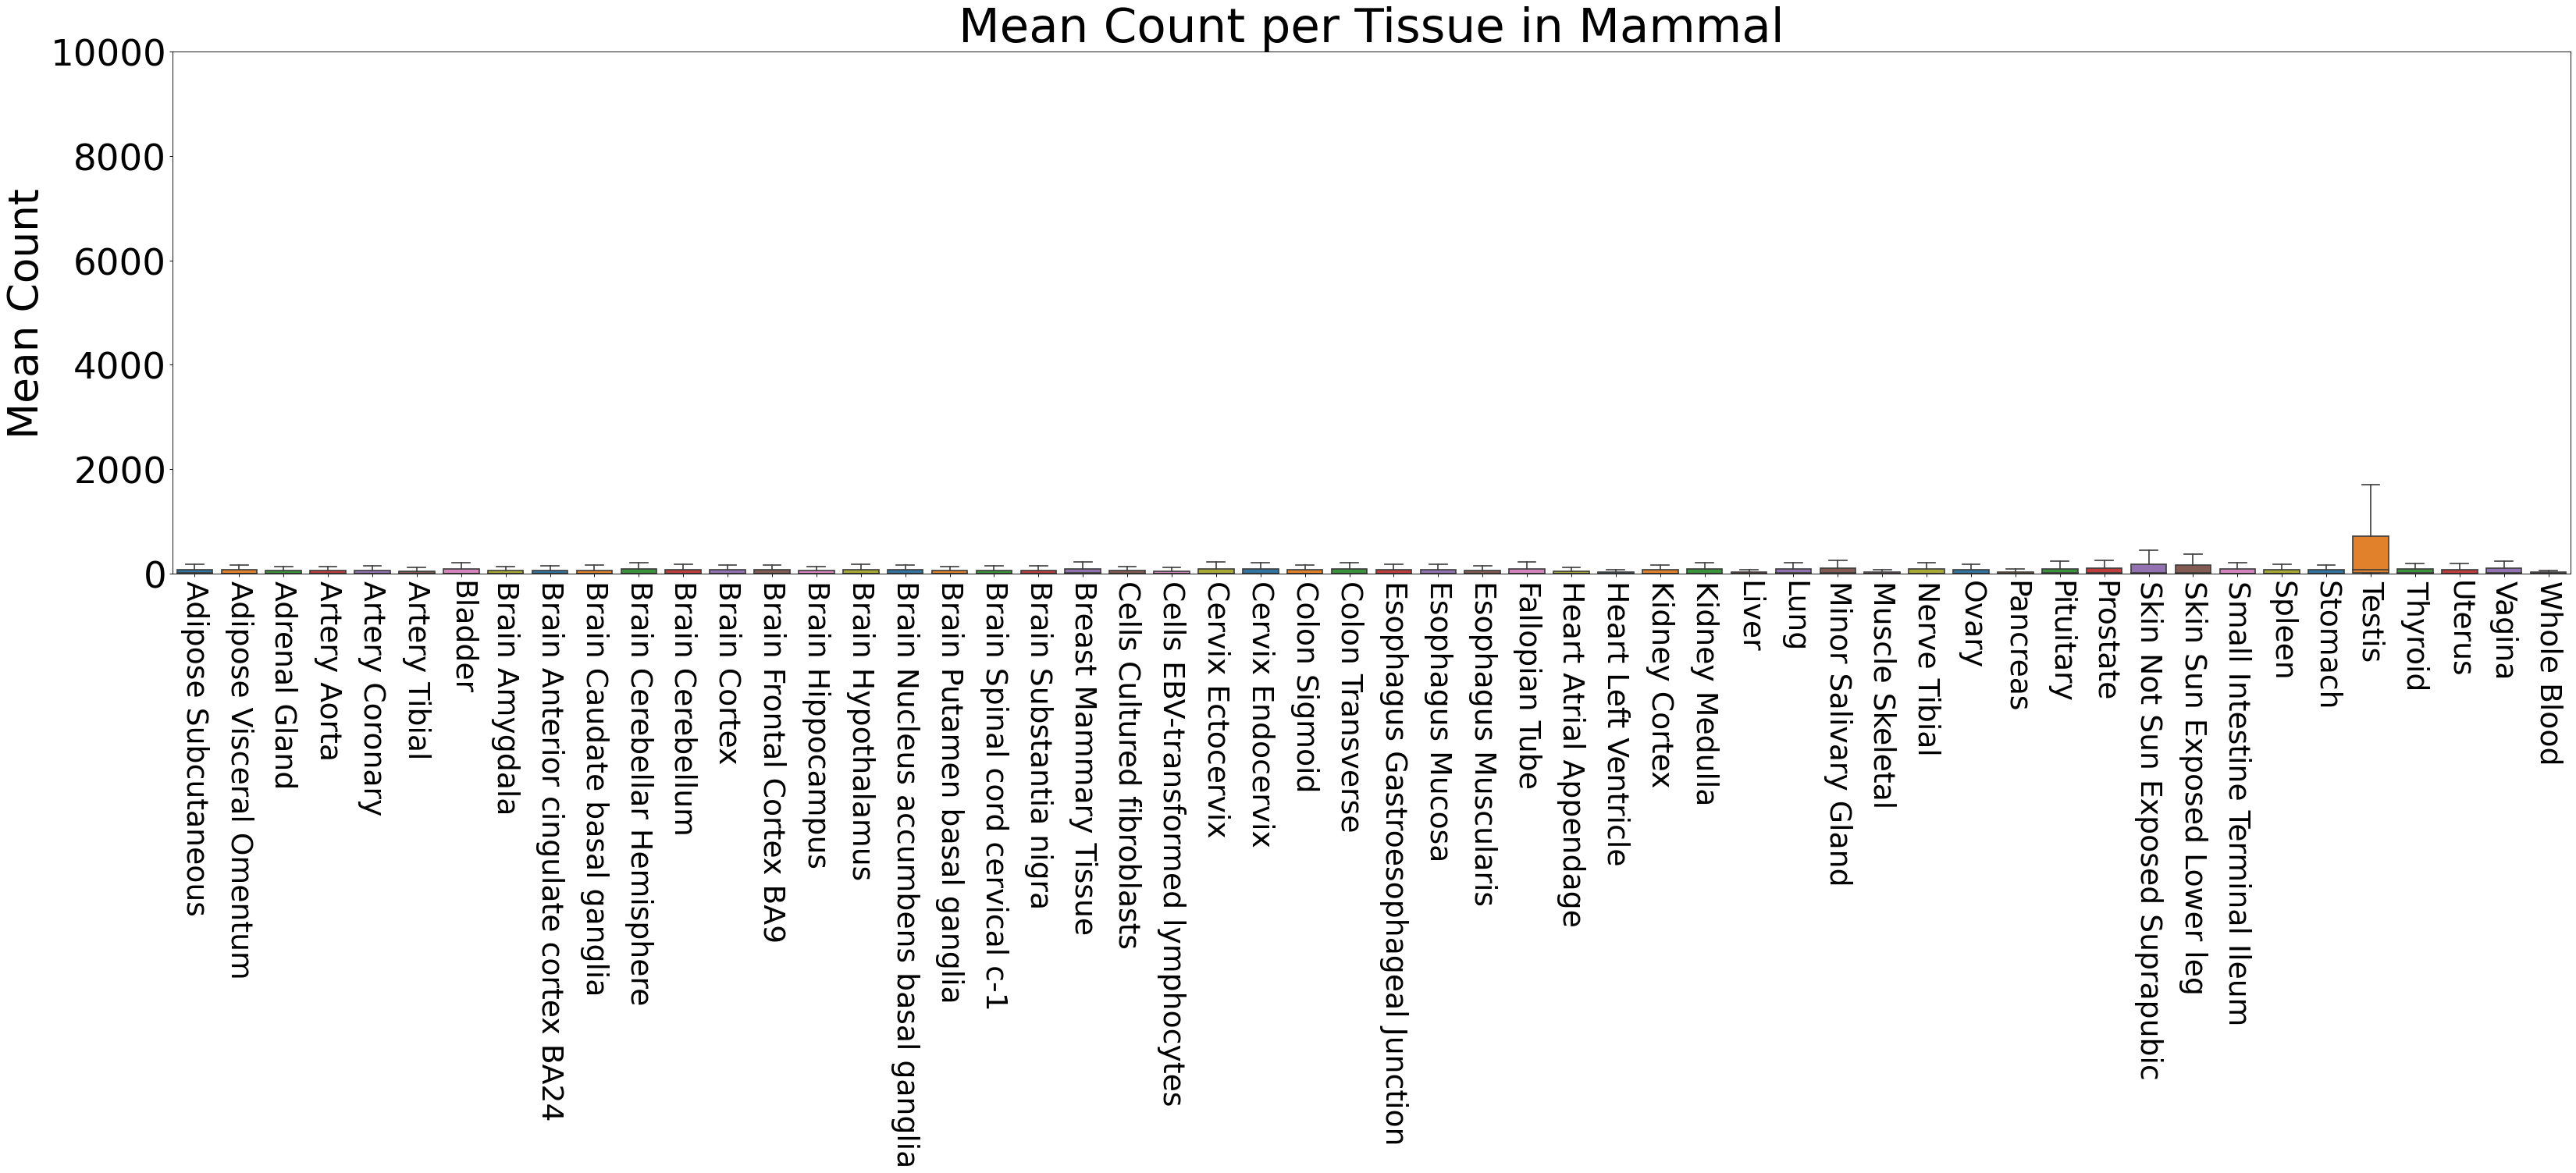

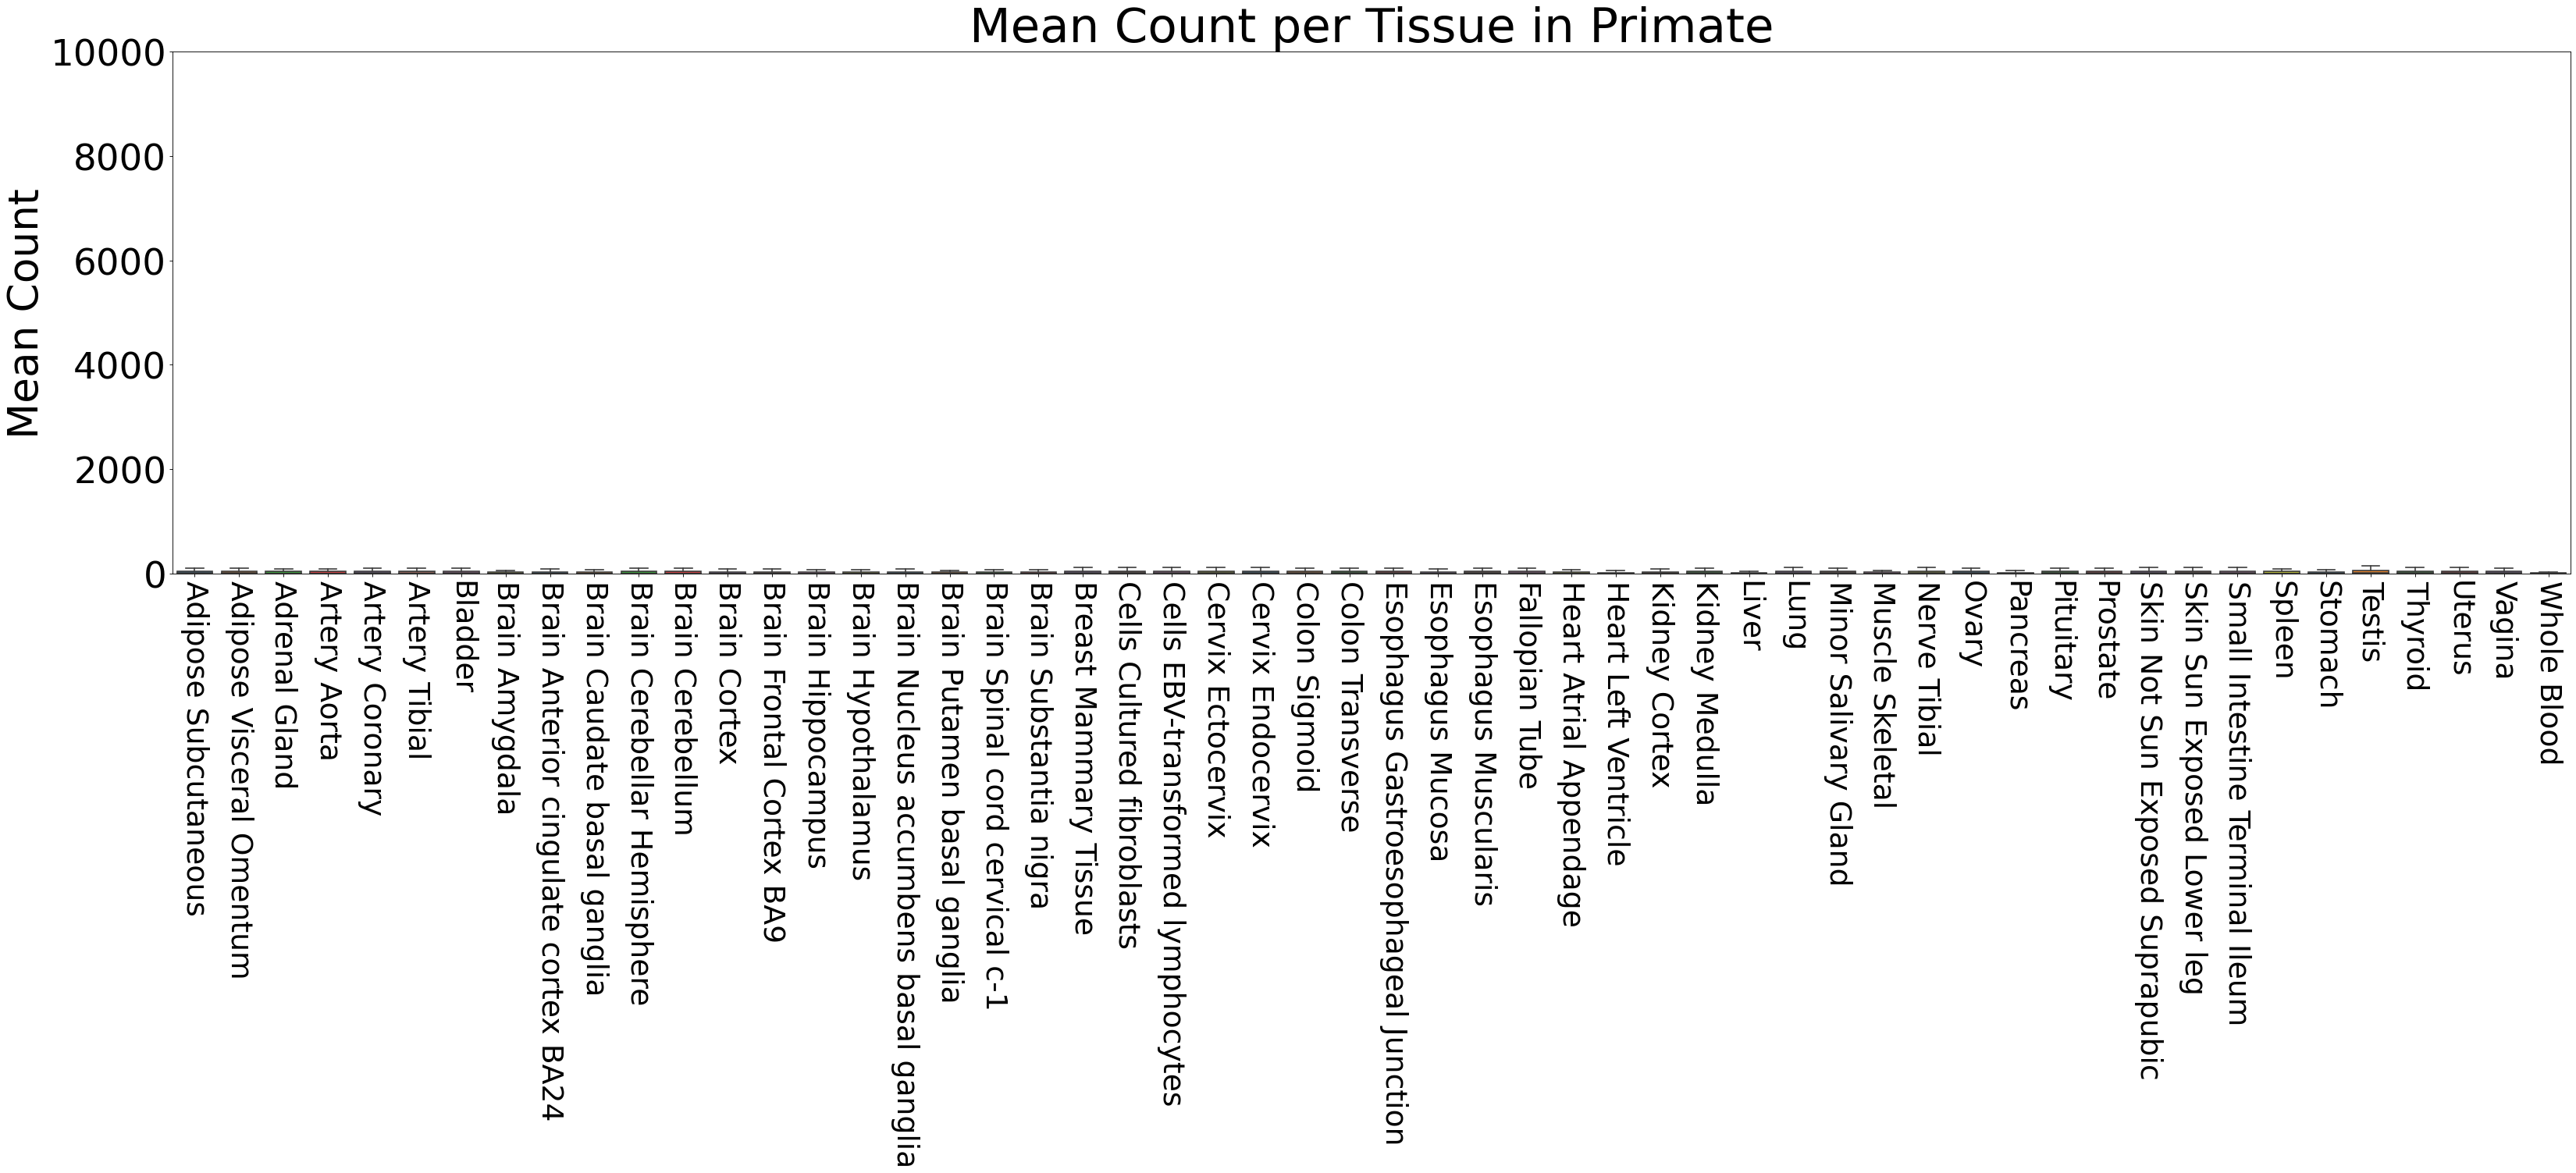

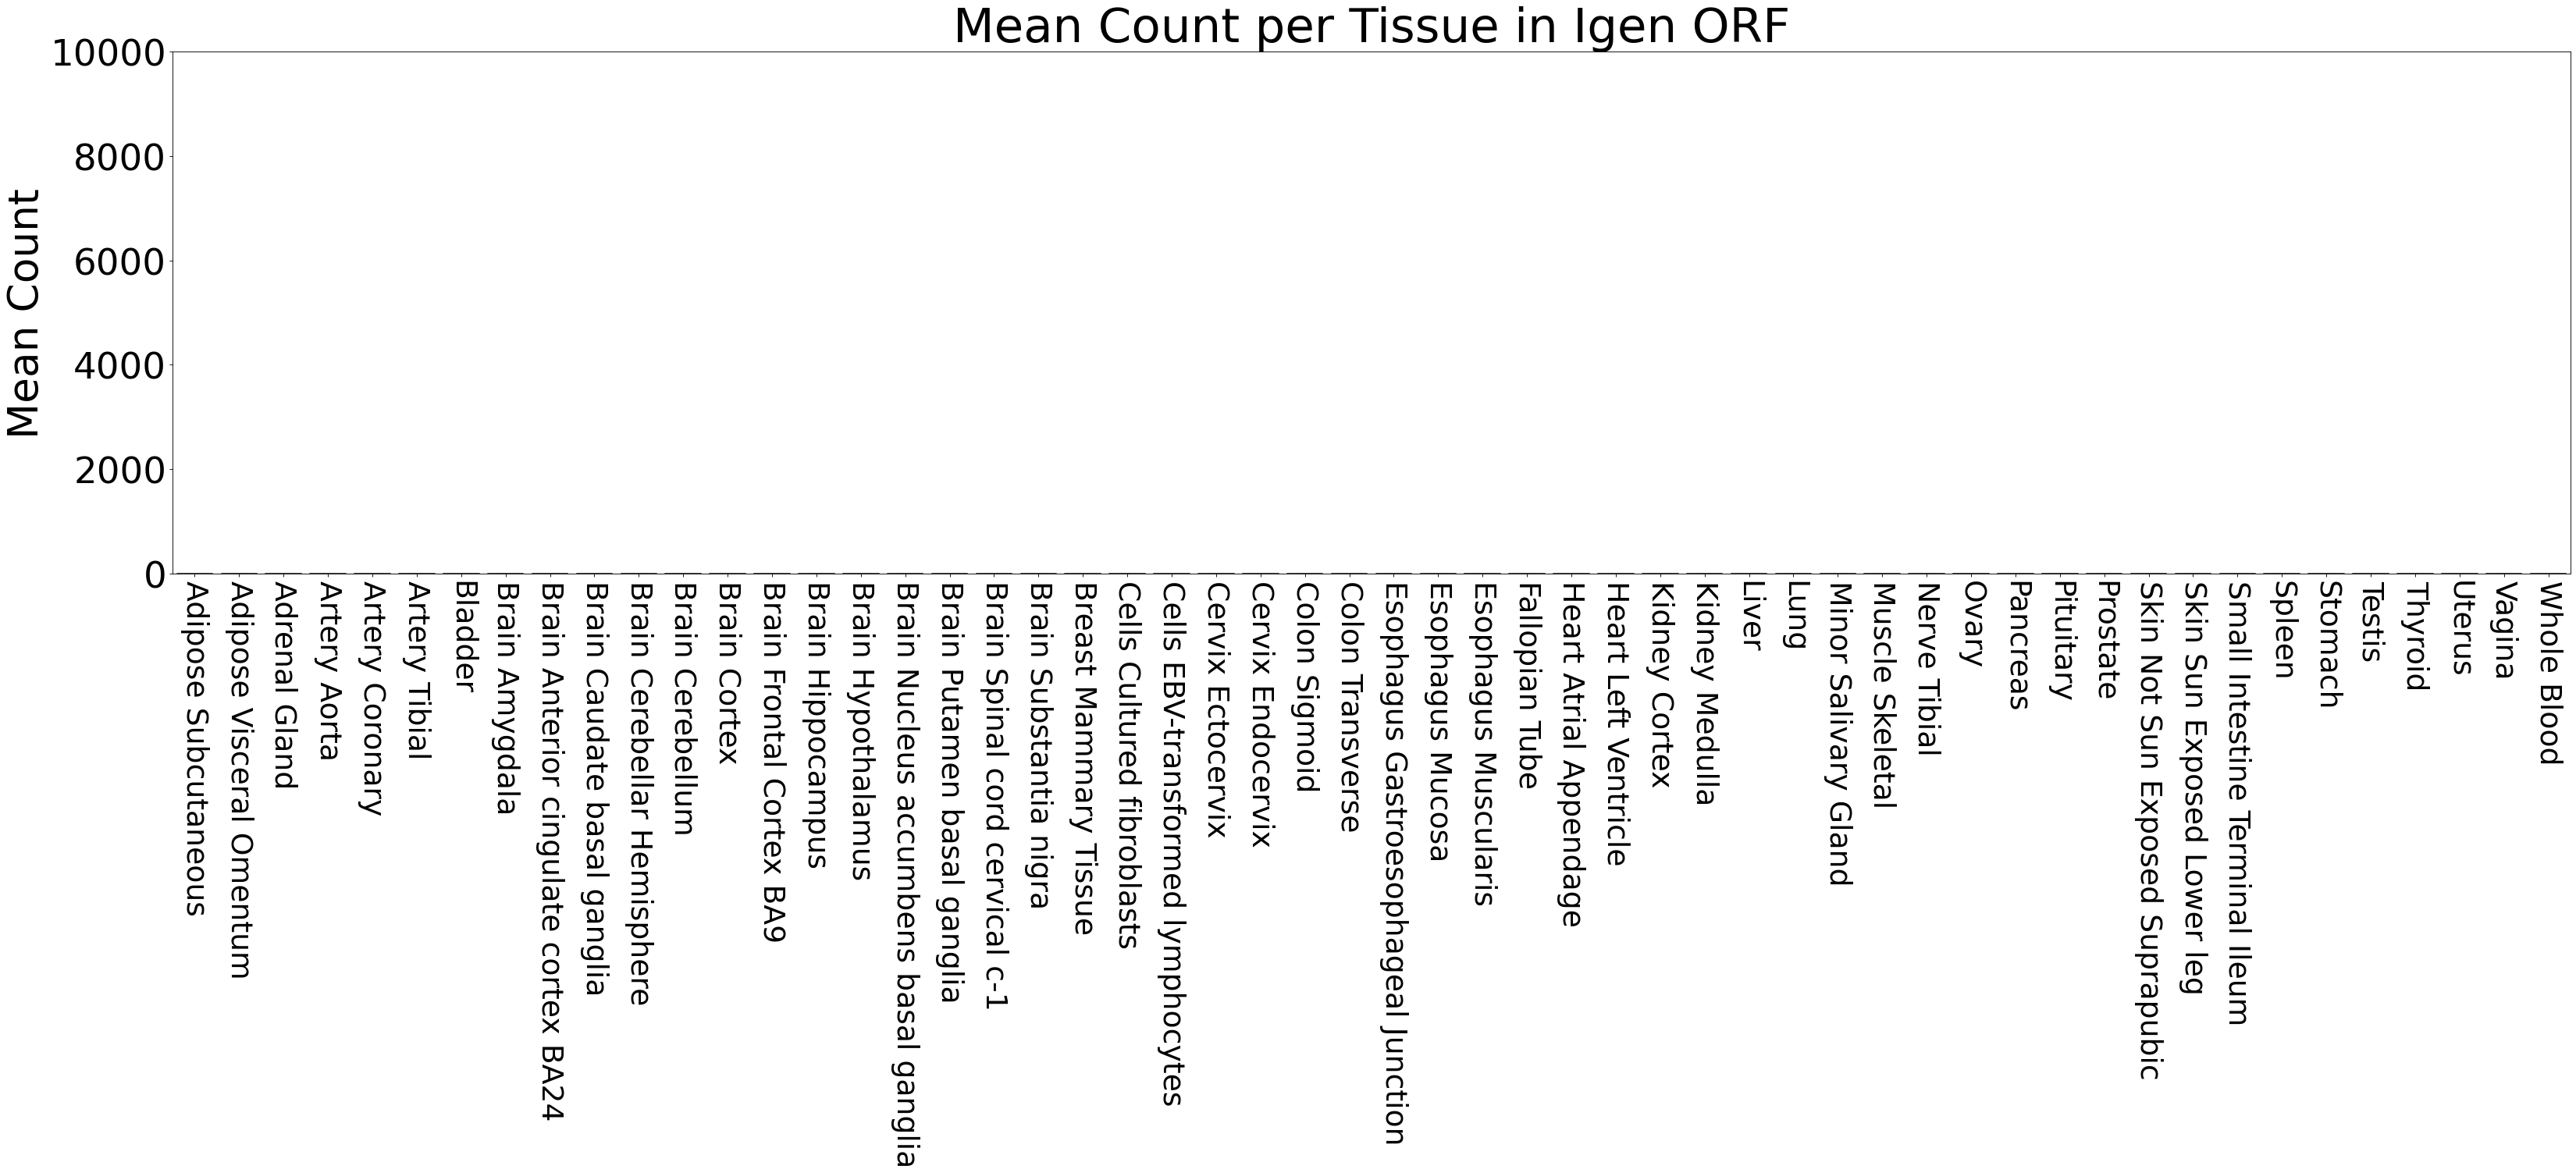

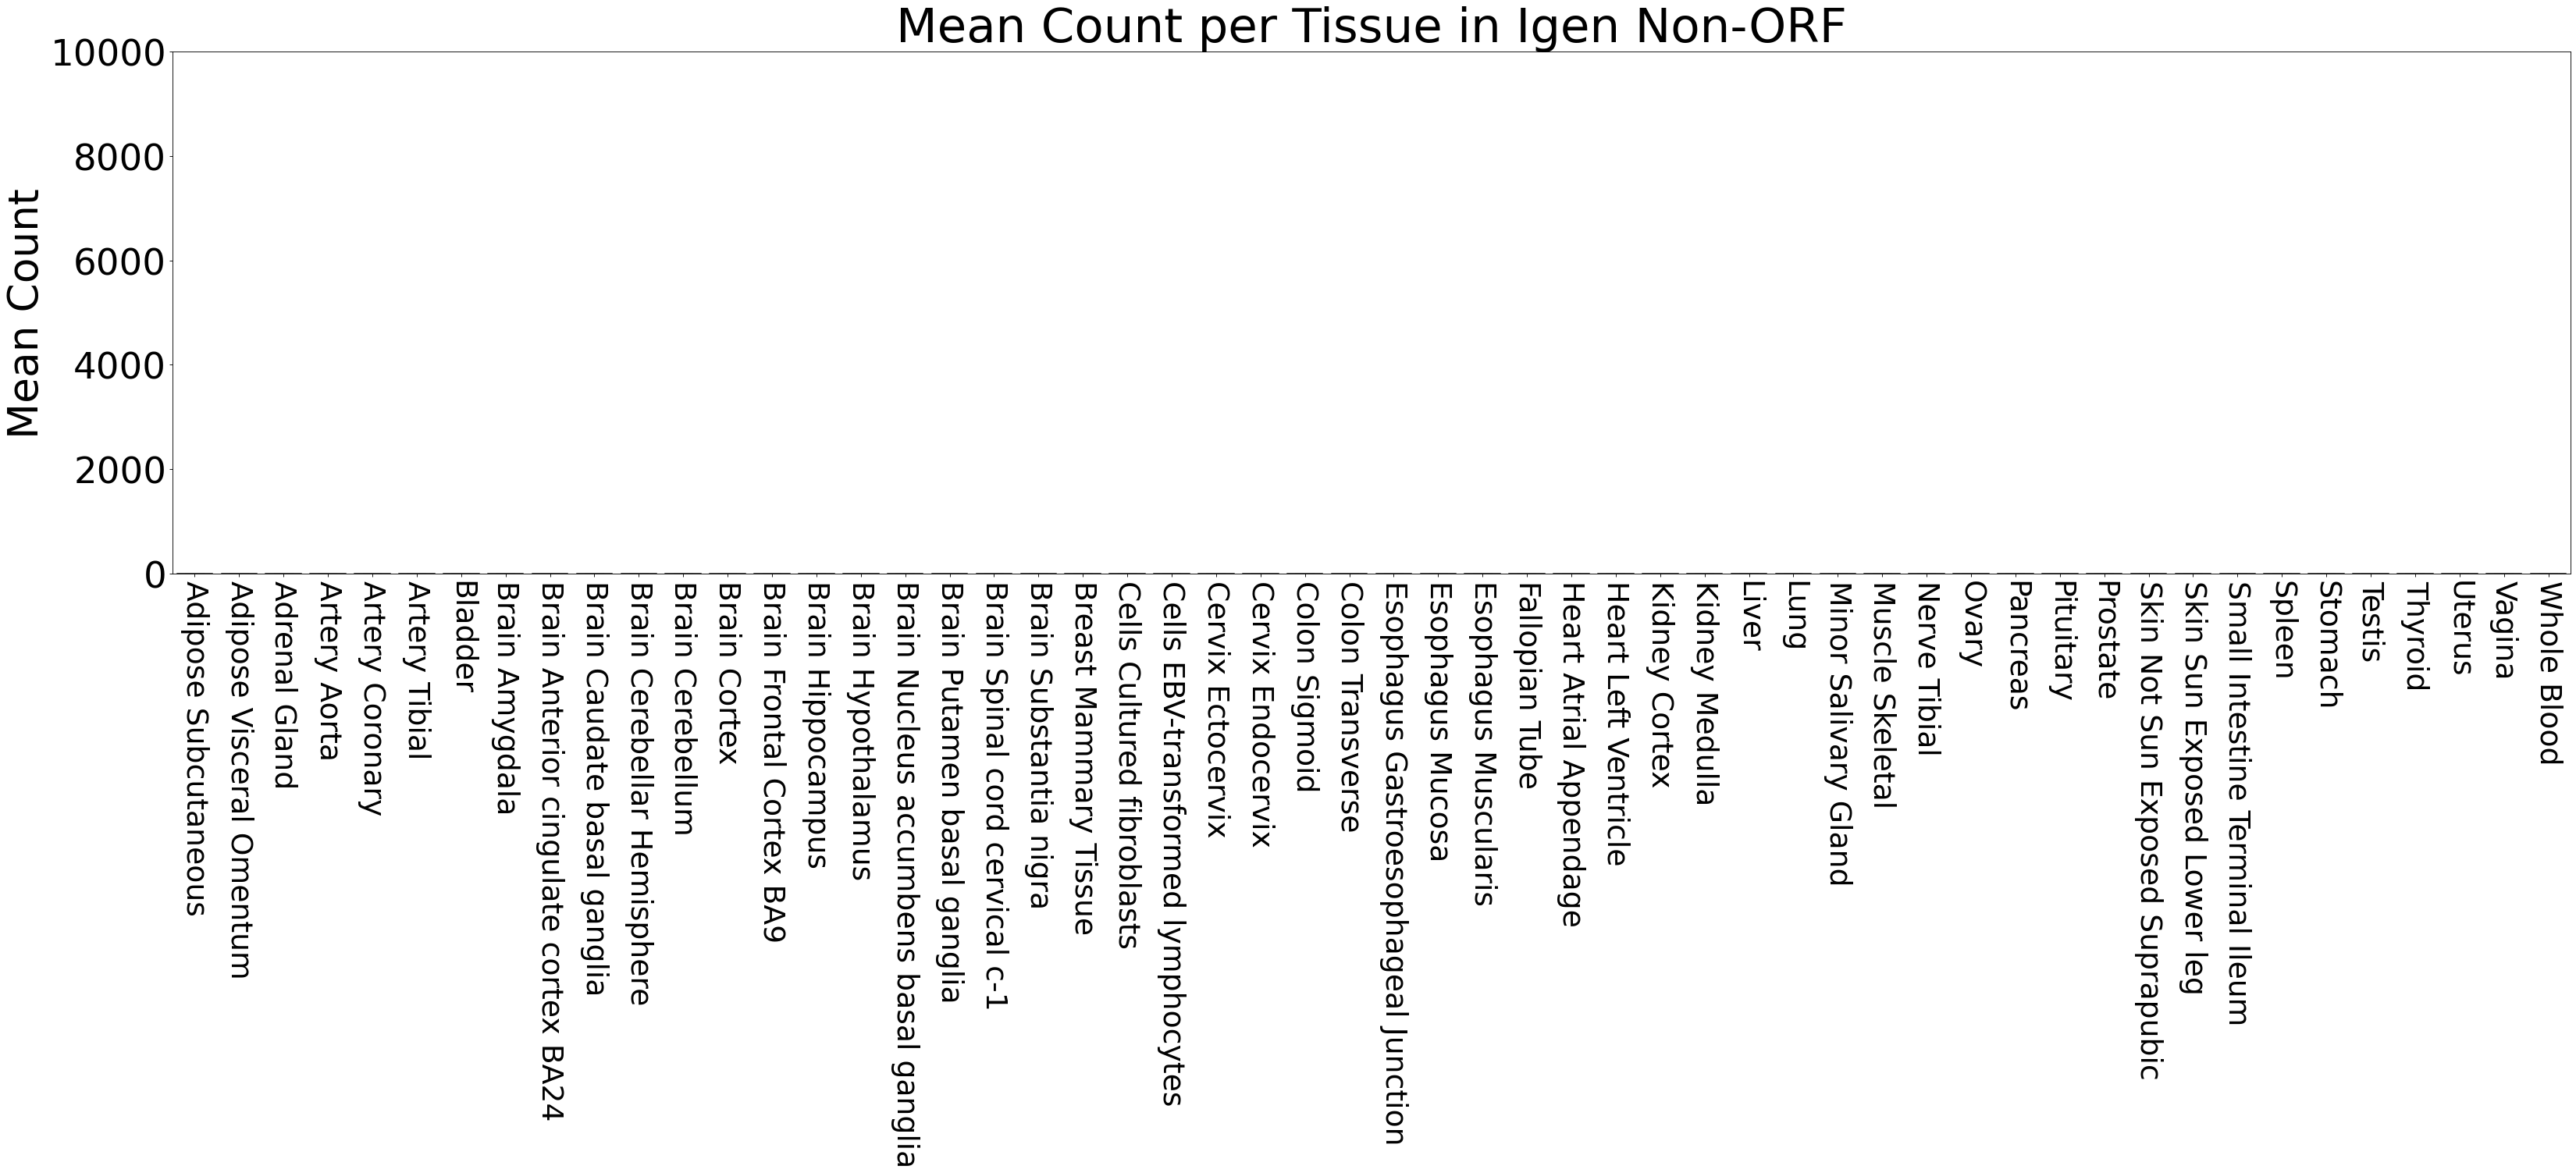

In [36]:
# Plot Set #6 - graphs to show all tissue expression within a given evolutionary category  

for v5_era in ['Ancient','Metazoan','Chordate','Mammal','Primate','Igen ORF','Igen Non-ORF']:

    era_specifici_df = v5_temp[v5_temp.evoera5==v5_era]
    

    plt.figure(figsize=(48,22), dpi=80)
    sns.boxplot(data=era_specifici_df,x="tissuetype",y="mc",showfliers=False,palette=repeating)#,palette='viridis')    
    xOnes,xTwos = plt.xticks()
    xTwos = list(list(govt_names.values())[:54])
    
    for xi in range(len(xTwos)):
        xTwos[xi] = xTwos[xi].replace('_',' ')#.replace(' ','\n',1)
        
    plt.xticks(xOnes,xTwos,rotation=-90,size=34)
    plt.yticks(size=42)
    plt.title(f'Mean Count per Tissue in {v5_era}',size=55,pad=10)
    plt.xlabel(None)
    plt.ylabel("Mean Count",size=48)
    plt.subplots_adjust(left=0.1,bottom=0.5)

    plt.ylim([0,10000])

    xOne,xTwo = plt.xticks()

    image_name = f'fig5-meancount-per-all-tissues-by-{v5_era}-metazoanigen-{date_name}'
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/png/{image_name}.png',bbox_inches="tight")
    plt.savefig(f'/Users/marten/Serious_Work/Batch_Scripts/unannotated-genes-with-all/marten_gtexplotting_jupyter_mc_{date_name}/pdf/{image_name}.pdf',bbox_inches="tight")


    plt.show()

In [37]:
# list(set(list(govt_names.values())))[:54]